This notebook was used for all analyses reported in:

> Dubois, J.*, Galdi, P.*, Paul, L.K. and Adolphs, R. Resting-state functional brain connectivity best predicts the personality dimension of openness to experience. Under review.

Please cite the work appropriately if you re-use (parts of) this code for your own research.

The code is provided as is, for documentation purposes. 
It was run on a HPC cluster with CentOS release 6.3, linux kernel 2.6.32-279.el6.x86_64

Questions can be addressed to Julien Dubois (jcrdubois@gmail.com) and Paola Galdi (paola.galdi@gmail.com)

In [1]:
from HCP_helpers import *
%load_ext rpy2.ipython
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
# should figures be saved as files
exportFigs = True

confoundLists = {
    'all':['gender','age','handedness','age^2','gender*age','gender*age^2','brainsize','motion','recon','PMAT24_A_CR'],
    'deconH':['gender','age','handedness','brainsize','motion','recon'],
    'deconH+IQ':['gender','age','handedness','brainsize','motion','recon','PMAT24_A_CR'],
    'decon00':['brainsize','motion','recon'],
    'noDecon':[]
}

In [2]:
%%R 
library(ggplot2)
library(psych)
library(Hmisc)
library(corrplot)
library(colorRamps)

/home/duboisjx/software/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘psych’


  warnings.warn(x, RRuntimeWarning)
/home/duboisjx/software/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


  warnings.warn(x, RRuntimeWarning)
/home/duboisjx/software/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: lattice

  warnings.warn(x, RRuntimeWarning)
/home/duboisjx/software/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: survival

  warnings.warn(x, RRuntimeWarning)
/home/duboisjx/software/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Formula

  warnings.warn(x, RRuntimeWarning)
/home/duboisjx/software/anaconda2/lib/python2.7/s

# Set parameters

In [3]:
# config is a global variable used by several functions
# Where does the HCP data live?
config.DATADIR                 = '/scratch/duboisjx/data/HCP/MRI'
# list available runs
fmriRuns                       = ['rfMRI_REST1_LR','rfMRI_REST1_RL','rfMRI_REST2_LR','rfMRI_REST2_RL']

# which file to use for the functional data?
#the code #fMRIrun# will be replaced by the appropriate run
config.fmriFileTemplate        = '#fMRIrun#_Atlas_MSMAll.dtseries.nii'
# parcellation for FC matrix
config.parcellationName        = 'Glasser' #used for easy reference
config.parcellationFile        = '/scratch/duboisjx/data/parcellations/Glasser2016/Parcels.dlabel.nii'
config.nParcels                = 360
config.isCifti                 = True

# other naming conventions
config.melodicFolder           = op.join('#fMRIrun#_hp2000.ica','filtered_func_data.ica') 
config.movementRelativeRMSFile = 'Movement_RelativeRMS.txt'
config.movementRegressorsFile  = 'Movement_Regressors_dt.txt'
# it is advisable to run the analyses on a cluster with sge
config.queue        = True
parallelEnvironment = 'smp' #'openmp'

# Subject selection

The following criteria were applied to select subjects for the analyses.
- Subjects must have completed all resting-state fMRI scans, as well as all relevant neuropsychological testing.
- Subject with a score MMSE below 26 are excluded, since it could indicate severe cognitive impairment. 
- Subjects with a root-mean-squared frame-to-frame head motion estimate exceeding 0.15 mm in any of the 4 resting-state runs were exluded.

Note that score NEOFAC_A [agreeableness factor] had to be recomputed (see [here](https://www.mail-archive.com/hcp-users@humanconnectome.org/msg05266.html): it appears that one of the test items was not properly reverse coded to compute the agreeableness factor).

In [4]:
# Which release should subjects be selected from?
config.release                 = 'all+MEG2'
# where are the .csv files with subject scores and info?
# unrestricted
config.behavFile               = '/scratch/duboisjx/data/HCP/neuropsych/unrestricted_luckydjuju_6_7_2017_0_44_41.csv'
# RESTRICTED: needed for age, handedness, family structure,...
config.RbehavFile              = '/scratch/duboisjx/data/HCP/neuropsych/RESTRICTED_luckydjuju_8_22_2017_11_13_18.csv'


Udf = pd.read_csv(config.behavFile)
Rdf = pd.read_csv(config.RbehavFile)
# merge unrestricted and restricted
df = pd.merge(Udf,Rdf,how='inner')
# keep only variables of interest
df = df[['Subject','Release','Gender','Age_in_Yrs','fMRI_3T_ReconVrs',
         'FS_BrainSeg_Vol','MMSE_Score',
        'Family_ID','Father_ID','Mother_ID','Race','Ethnicity','Handedness', #'Twin_Stat','Zygosity',
        '3T_RS-fMRI_PctCompl','PMAT_Compl','NEO-FFI_Compl','MMSE_Compl',
        'Non-TB_Compl','VisProc_Compl','DelDisc_Compl','SCPT_Compl','IWRD_Compl','VSPLOT_Compl', 
        'NEOFAC_O','NEOFAC_C','NEOFAC_E','NEOFAC_A','NEOFAC_N',
        'NEORAW_01','NEORAW_02','NEORAW_03','NEORAW_04','NEORAW_05','NEORAW_06','NEORAW_07','NEORAW_08','NEORAW_09','NEORAW_10',
        'NEORAW_11','NEORAW_12','NEORAW_13','NEORAW_14','NEORAW_15','NEORAW_16','NEORAW_17','NEORAW_18','NEORAW_19','NEORAW_20',
        'NEORAW_21','NEORAW_22','NEORAW_23','NEORAW_24','NEORAW_25','NEORAW_26','NEORAW_27','NEORAW_28','NEORAW_29','NEORAW_30',
        'NEORAW_31','NEORAW_32','NEORAW_33','NEORAW_34','NEORAW_35','NEORAW_36','NEORAW_37','NEORAW_38','NEORAW_39','NEORAW_40',
        'NEORAW_41','NEORAW_42','NEORAW_43','NEORAW_44','NEORAW_45','NEORAW_46','NEORAW_47','NEORAW_48','NEORAW_49','NEORAW_50',
        'NEORAW_51','NEORAW_52','NEORAW_53','NEORAW_54','NEORAW_55','NEORAW_56','NEORAW_57','NEORAW_58','NEORAW_59','NEORAW_60',
        'CardSort_Unadj','Flanker_Unadj','ListSort_Unadj','PicSeq_Unadj','PicVocab_Unadj','ProcSpeed_Unadj','ReadEng_Unadj',
        'IWRD_TOT','PMAT24_A_CR','VSPLOT_TC'
        ]]
# replace labeled columns with dummies
df['Gender'].replace(['F','M'],[1,2],inplace=True)
df['fMRI_3T_ReconVrs'].replace(['r177','r177 r227','r227'],[1,2,3],inplace=True)

# RECOMPUTE PERSONALITY FACTOR SCORES
scoring = [ 
    {
    'O1':{'13':'n', '23':'r', '43':'n'}, #aesthetic interests
    'O2':{'48':'r', '53':'n', '58':'n'}, #intellectual interests
    'O3':{'03':'r', '08':'r', '18':'r', '38':'r'}, # unconventionality
    'O4':{'28':'n', '33':'r'}, #??
    },
    {
    'C1':{'05':'n', '10':'n', '15':'r', '30':'r', '55':'r'}, # orderliness
    'C2':{'25':'n', '35':'n', '60':'n'}, # goal-striving
    'C3':{'20':'n', '40':'n', '45':'r', '50':'n'}, # dependability
    },
    {
    'E1':{'07':'n', '12':'r', '37':'n', '42':'r'}, # positive affect
    'E2':{'02':'n', '17':'n', '27':'r', '57':'r'}, # sociability
    'E3':{'22':'n', '32':'n', '47':'n', '52':'n'}, # activity
    },
    {
    'A1':{'09':'r', '14':'r', '19':'n', '24':'r', '29':'r', '44':'r', '54':'r', '59':'r'}, #nonantagonistic orientation
    'A2':{'04':'n', '34':'n', '39':'r', '49':'n'}, # prosocial orientation
    },
    {
    'N1':{'01':'r', '11':'n', '16':'r', '31':'r', '46':'r'}, # negative affect
    'N2':{'06':'n', '21':'n', '26':'n', '36':'n', '41':'n', '51':'n', '56':'n'} # self-reproach
    }
    ]
# RECOMPUTE PERSONALITY FACTOR SCORES
factors = ['O','C','E','A','N']
scoreL  = ['NEOFAC_O', 'NEOFAC_C', 'NEOFAC_E', 'NEOFAC_A_corr', 'NEOFAC_N']
diff     = list()
for iFac,factor in enumerate(factors):
    thisF       = np.zeros(df.shape[0]) # FACTOR
    for fkey in scoring[iFac].keys(): # facets
        thisf   = np.zeros(df.shape[0]) #facet
        for Ikey in scoring[iFac][fkey].keys(): # items
            if scoring[iFac][fkey][Ikey]=='n':
                df['NEORAW_'+Ikey].replace(['SD','D','N','A','SA'],[0,1,2,3,4],inplace=True)
            else:
                df['NEORAW_'+Ikey].replace(['SD','D','N','A','SA'],[4,3,2,1,0],inplace=True)
            thisf = thisf + df['NEORAW_'+Ikey]
        df['NEOFAC_'+fkey]=thisf
        thisF = thisF + thisf
    df['NEOFAC_'+factor+'_calc']=thisF
    diff.append(np.sum(np.abs(df['NEOFAC_'+factor]-df['NEOFAC_'+factor+'_calc'])))
print 'diffO={0:d}, diffC={1:d}, diffE={2:d}, diffA={3:d}, diffN={4:d}'.format(
    np.int(diff[0]),np.int(diff[1]),np.int(diff[2]),np.int(diff[3]),np.int(diff[4]))
# correct scores
df['NEOFAC_A_corr']  = df['NEOFAC_A_calc']

# select subjects according to release
if config.release == 'Q2':
    keepSub = (df['Release'] == 'Q2') | (df['Release'] == 'Q1')
elif config.release == 'S500':
    keepSub = (df['Release'] == 'Q3') | (df['Release'] == 'S500')
elif config.release == 'Q2+S500':
    keepSub = (df['Release'] == 'Q2') | (df['Release'] == 'Q1') | (df['Release'] == 'Q3') | (df['Release'] == 'S500')
elif config.release == 'S900':
    keepSub = (df['Release'] == 'S900')
elif config.release == 'S1200':
    keepSub = (df['Release'] == 'S1200')
elif config.release == 'all':
    keepSub = ((df['Release'] == 'Q1') | (df['Release'] == 'Q2') | (df['Release'] == 'Q3') 
           | (df['Release'] == 'S500') | (df['Release'] == 'S900') | (df['Release'] == 'S1200'))
elif config.release == 'all+MEG2':
    keepSub = ((df['Release'] == 'Q1') | (df['Release'] == 'Q2') | (df['Release'] == 'Q3') 
           | (df['Release'] == 'S500') | (df['Release'] == 'S900') | (df['Release'] == 'S1200') 
           | (df['Release'] == 'MEG2'))
else:
    sys.exit("Invalid release code")
print 'Selected {} subjects for release {}'.format(np.sum(keepSub),config.release)

# select subjects that have completed all neuropsych
keepSub = keepSub & (
    (df['PMAT_Compl']==True) &
    (df['NEO-FFI_Compl']==True) &
    (df['MMSE_Compl']==True) &
    (df['Non-TB_Compl']==True) &
    (df['VisProc_Compl']==True) &
    (df['SCPT_Compl']==True) &
    (df['IWRD_Compl']==True) &
    (df['VSPLOT_Compl']==True)
    )
print 'Selected {} subjects with complete neuropsych data'.format(np.sum(keepSub))

# FURTHER EXCLUSIONARY CRITERIA
keepSub    = np.logical_and(keepSub,np.logical_not(np.isnan(df['CardSort_Unadj'])))
keepSub    = np.logical_and(keepSub,np.logical_not(np.isnan(df['VSPLOT_TC'])))
keepSub    = np.logical_and(keepSub,np.logical_not(np.isnan(df['PicSeq_Unadj'])))
keepSub    = np.logical_and(keepSub,np.logical_not(np.isnan(df['NEORAW_01'])))
print 'Kept {} subjects after removing missing values'.format(np.sum(keepSub))

# --> MMSE <26 excluded
keepSub    = np.logical_and(keepSub,df['MMSE_Score']>=26)
print 'Kept {} subjects after MMSE<26 exclusion criterion'.format(np.sum(keepSub))

# PRUNE df 
df        = df[keepSub]
# reindex
df.index  = range(df.shape[0])

print 'Included data for FACTOR ANALYSIS: {} subjects [{} F, {:0.1f}+/-{:0.1f} range {}-{} y.o.]'.format(
    len(df),np.sum(df['Gender']==1),np.mean(df['Age_in_Yrs']),np.std(df['Age_in_Yrs']),np.min(df['Age_in_Yrs']),np.max(df['Age_in_Yrs']))

diffO=0, diffC=0, diffE=0, diffA=2682, diffN=0
Selected 1206 subjects for release all+MEG2
Selected 1188 subjects with complete neuropsych data
Kept 1183 subjects after removing missing values
Kept 1181 subjects after MMSE<26 exclusion criterion
Included data for FACTOR ANALYSIS: 1181 subjects [638 F, 28.8+/-3.7 range 22-37 y.o.]


In [5]:
# FURTHER PRUNE SUBJECTS FOR MRI ANALYSIS
# Exclusion of subjects who did not complete all RS-fMRI
keepSub = (df['3T_RS-fMRI_PctCompl']==100)
print 'Kept {} subjects with complete rfMRI datasets'.format(np.sum(keepSub))

# Exclusion of high-motion subjects
# exclude subjects with >0.15 frame-to-frame head motion estimate averged across both rest runs (arbitrary threshold as in Finn et al 2015)
RelRMSMean = np.zeros([len(df['Subject']), len(fmriRuns)],dtype=np.float32)
FDsum      = np.zeros([len(df['Subject']), len(fmriRuns)],dtype=np.float32)
iSub=0
excluded = list()
for subject in df['Subject']:
    if keepSub[iSub] is False:
        iSub=iSub+1
        continue
    config.subject=str(subject)
    # RelRMSMean
    i=0
    for config.fmriRun in fmriRuns:
        RelRMSMeanFile = op.join(buildpath(), 'Movement_RelativeRMS_mean.txt')
        if op.isfile(RelRMSMeanFile):
            with open(RelRMSMeanFile,'r') as tmp:
                RelRMSMean[iSub,i] = float(tmp.read())
        else:
            keepSub[iSub]=False
            excluded.append(config.subject)
            break
        i=i+1
    if i==len(fmriRuns): # all RelRMSMeanFile exist
        if np.any(RelRMSMean[iSub,:] > 0.15):
            keepSub[iSub]=False
            excluded.append(config.subject)
        else:
            keepSub[iSub]=True
    # total framewise displacement
    i=0
    for config.fmriRun in fmriRuns:
        FDsumFile = op.join(buildpath(), 'FD_sum.txt')
        if not op.isfile(FDsumFile):
            motionFile = op.join(buildpath(), config.movementRegressorsFile)
            if op.isfile(motionFile):
                dmotpars = np.abs(np.genfromtxt(motionFile)[:,6:]) #derivatives
                headradius=50 #50mm as in Powers et al. 2012
                disp=dmotpars.copy()
                disp[:,3:]=np.pi*headradius*2*(disp[:,3:]/360)
                thisFDsum=np.sum(np.sum(disp,1),0)
                with open(FDsumFile,'w') as tmp:
                    tmp.write(str(thisFDsum))
            else:
                break
        with open(FDsumFile,'r') as tmp:
            FDsum[iSub,i] = float(tmp.read())
        i=i+1
    iSub=iSub+1

# add RelRMSMean and FDsum to the dataframe
df['RelRMSMean_REST1'] = np.mean(RelRMSMean[:,0:2],axis=1)
df['FDsum_REST1']      = np.mean(FDsum[:,0:2],axis=1)
df['RelRMSMean_REST2'] = np.mean(RelRMSMean[:,2:4],axis=1)
df['FDsum_REST2']      = np.mean(FDsum[:,2:4],axis=1)

print 'Kept {} subjects with motion <0.15mm'.format(np.sum(keepSub))

df         = df[keepSub]
df.index   = range(df.shape[0])
print 'Included data for MRI analysis: {} subjects [{} F, {:0.1f}+/-{:0.1f} range {}-{} y.o.]'.format(
    len(df),np.sum(df['Gender']==1),np.mean(df['Age_in_Yrs']),np.std(df['Age_in_Yrs']),np.min(df['Age_in_Yrs']),np.max(df['Age_in_Yrs']))

Kept 988 subjects with complete rfMRI datasets
Kept 884 subjects with motion <0.15mm
Included data for MRI analysis: 884 subjects [475 F, 28.6+/-3.7 range 22-36 y.o.]


## Cronbach's alpha

In [6]:
factors = ['O','C','E','A','N']
factorKeys = list()
for iFac,factor in enumerate(factors):
    itemKeys = list()
    for fkey in scoring[iFac].keys(): # facets
        for Ikey in scoring[iFac][fkey].keys(): # items
            itemKeys.append('NEORAW_'+Ikey)
    factorKeys.append(itemKeys)

In [7]:
%%R -i df,factorKeys -o Calpha
rdf <- data.frame(df);
Calpha <- vector()
for (i in seq(1,ncol(factorKeys))){
    keys<-unlist(factorKeys[,i])
    Calpha[i]<-alpha(df[,keys])$total$raw_alpha
}

In [8]:
print factors
print Calpha

['O', 'C', 'E', 'A', 'N']
[ 0.75720668  0.81194719  0.77790728  0.75705505  0.84960006]


## Confound removal assessment

In [9]:
decon_ = 'deconH'

# make a matrix with all confounds
conMatAll = None
for confound in confoundLists['all']:
    conVec = defConVec(df,confound,'REST1')
    # add to conMat
    if conMatAll is None:
        conMatAll = np.array(np.ravel(conVec))
    else:
        conMatAll = np.vstack((conMatAll,conVec))
conMatAll = conMatAll.T

# check correlations with all confounds
print confoundLists['all']

scoreL = ['PMAT24_A_CR','NEOFAC_O','NEOFAC_C','NEOFAC_E','NEOFAC_A_corr','NEOFAC_N']
for score in scoreL:
    print score
    if decon_=='deconH':
        if score == 'PMAT24_A_CR':
            decon = decon_
        else:
            decon = decon_+'+IQ'
        
    # make a matrix with just the confounds used
    conMat = None
    for confound in confoundLists[decon]:
        conVec = defConVec(df,confound,'REST1')
        # add to conMat
        if conMat is None:
            conMat = np.array(np.ravel(conVec))
        else:
            conMat = np.vstack((conMat,conVec))
    conMat = conMat.T
    
    # correlations before
    corrBef = []
    for i in range(len(confoundLists['all'])):
        corrBef.append(stats.pearsonr(conMatAll[:,i].T,np.ravel(df[score]))[0])
    print(', '.join('{:03f}'.format(k) for k in corrBef))
    # regress out confounds
    regr        = linear_model.LinearRegression()
    regr.fit(conMat, np.ravel(df[score]))
    fittedvalues = regr.predict(conMat)
    deconScore   = np.ravel(df[score]) - np.ravel(fittedvalues)
    # correlations after
    corrAft = []
    for i in range(len(confoundLists['all'])):
        corrAft.append(stats.pearsonr(conMatAll[:,i].T,deconScore)[0])
    print(', '.join('{:03f}'.format(k) for k in corrAft))

['gender', 'age', 'handedness', 'age^2', 'gender*age', 'gender*age^2', 'brainsize', 'motion', 'recon', 'PMAT24_A_CR']
PMAT24_A_CR
0.146405, -0.095038, -0.005959, -0.096341, 0.107937, 0.060247, 0.274458, -0.118426, 0.050258, 1.000000
-0.000000, 0.000000, 0.000000, -0.000153, -0.003238, -0.006589, -0.000000, 0.000000, -0.000000, 0.954651
NEOFAC_O
0.108914, -0.104116, -0.066861, -0.104150, 0.073360, 0.032895, 0.116372, -0.127077, 0.072037, 0.221891
-0.000000, 0.000000, 0.000000, 0.000329, 0.004757, 0.007424, -0.000000, 0.000000, -0.000000, -0.000000
NEOFAC_C
-0.114147, 0.072689, 0.007191, 0.071100, -0.090611, -0.059493, -0.153230, 0.011144, -0.040865, -0.057678
0.000000, -0.000000, -0.000000, -0.001921, -0.003673, -0.006666, 0.000000, -0.000000, 0.000000, 0.000000
NEOFAC_E
0.005376, -0.052663, -0.048790, -0.052032, -0.017971, -0.035713, 0.011548, 0.039369, 0.056685, -0.071144
-0.000000, 0.000000, 0.000000, 0.000478, -0.003634, -0.006504, -0.000000, 0.000000, -0.000000, -0.000000
NEOFAC_A_

### run preprocessing & prediction for all conditions!

Three different preprocessing pipelines were compared (on volume and surface data):
- <b>Pipeline A</b> reproduces as closely as possible the strategy described in (Finn et al., 2015) and consists of seven consecutive steps: 1) the signal at each voxel is z-score normalized; 2) using tissue masks, temporal drifts from cerebrospinal fluid (CSF) and white matter (WM) are removed with third-degree Legendre polynomial regressors; 3) the mean signals of CSF and WM are computed and regressed from gray matter voxels; 4) translational and rotational realignment parameters and their temporal derivatives are used as explanatory variables in motion regression; 5) signals are low-pass filtered with a Gaussian kernel with a standard deviation of 1 TR, i.e. 720ms in the HCP dataset; 6) the temporal drift from gray matter signal is removed using a third-degree Legendre polynomial regressor; 7) global signal regression is performed.
- <b>Pipeline B</b>, described in (Ciric et al., 2017; Satterthwaite, Wolf, et al., 2013), is composed of four steps in our implementation: 1) normalization at voxel-level is performed by subtracting the mean from each voxel’s time series; 2) linear and quadratic trends are removed with polynomial regressors; 3) temporal filtering is performed with a first order Butterworth filter with a passband between 0.01 and 0.08 Hz (after linearly interpolating volumes to be censored, cf. step 4); 4) tissue regression (CSF and WM signals with their derivatives and quadratic terms), motion regression (realignment parameters with their derivatives, quadratic terms and square of derivatives), global signal regression (whole brain signal with derivative and quadratic term), and censoring of volumes with a root-mean-squared (RMS) displacement that exceeded 0.25 mm are combined in a single regression model.
- <b>Pipeline C</b>, inspired by (Siegel et al., 2017), is implemented as follows: 1) an automated independent component (IC)-based denoising was performed with ICA-FIX (Salimi-Khorshidi et al., 2014). Instead of running ICA-FIX ourselves, we downloaded the FIX-denoised data which is available from the HCP database; 2) voxel signals were demeaned and 3) detrended with a first degree polynomial; 4) CompCor, a PCA-based method proposed by (Behzadi, Restom, Liau, & Liu, 2007) was applied to derive 5 components from CSF and WM signals; these were regressed out of the data, together with gray matter and whole-brain mean signals; volumes with a framewise displacement greater than 0.25 mm or a variance of differentiated signal (DVARS) greater than 105% of the run median DVARS were discarded as well; 5) temporal filtering was performed with a first-order Butterworth band-pass filter between 0.01 and 0.08 Hz, after linearly interpolating censored volumes.


Two linear regression models were used to predict subject measures:
- <b>Model (1)</b>, proposed by (Finn et al., 2015), consisting in a univariate regressor where the dependent variable is the score to be predicted and the explanatory variable is a scalar value that summarizes the functional connectivity network strength (i.e., the sum of edge weights). A filtering approach is used to select features (edges in the FC correlation matrix) that are correlated with the behavioral score on the training set: edges that correlate with the behavioral score with a p-value less than 0.01 are kept. Two distinct models are built using edges of the network that are positively and negatively correlated with the score, respectively. 
- <b>Model (2)</b>, that corresponds to Elastic Net multivariate regression, and uses the same filtering approach as for the univariate model (discard edges for which the p-value of the correlation with the behavioral score is greater than 0.01).


In the HCP dataset, several subjects are genetically related (in our final subject sample, there were 410 unique families). To avoid biasing the results due to this family structure (e.g., perhaps having a sibling in the training set would facilitate prediction for a test subject), predictive models were validated using a leave-one-family-out cross-validation scheme. 

In [10]:
checkPreproc = False
# turn this off to avoid lots of i/o, if you know all the subjects have been preprocessed already

In [11]:
# what2do has 6 possible values (it should be run with each)
# VA, VB, or VC:  volume, pipeline A, B or C
# SA, SB, or SC: surface, pipeline A, B or C
for what2do in ['VA','SA','VB0','SB0','VC0','SC0']:
    print '\n------------\n'+what2do+'\n------------\n'
    if what2do[0]=='S':
        # which file to use for the functional data?
        #the code #fMRIrun# will be replaced by the appropriate run
        config.fmriFileTemplate        = '#fMRIrun#_Atlas_MSMAll.dtseries.nii'
        # parcellation for FC matrix
        config.parcellationName        = 'Glasser' #used for easy reference
        config.parcellationFile        = '/scratch/duboisjx/data/parcellations/Glasser2016/Parcels.dlabel.nii'
        config.nParcels                = 360
        config.isCifti                 = True
    elif what2do[0]=='V':
        # which file to use for the functional data?
        #the code #fMRIrun# will be replaced by the appropriate run
        config.fmriFileTemplate        = '#fMRIrun#.nii.gz'
        # parcellation for FC matrix
        config.parcellationName        = 'shen2013'
        config.parcellationFile        = '/scratch/duboisjx/data/parcellations/shenetal_neuroimage2013_new/shen_2mm_268_parcellation.nii.gz'
        config.nParcels                = 268
        config.isCifti                 = False
        config.maskParcelswithGM       = False
        # add suffix indicating whether the parcels are masked with GM
        if config.maskParcelswithGM:
            config.parcellationName = config.parcellationName + '_GM'

    config.pipelineName  = what2do[1:]
    # output directory
    outDir              = op.join(config.DATADIR,'Results','PERSONALITY',config.pipelineName,config.parcellationName)
    if not op.isdir(outDir):
        makedirs(outDir)

    config.overwrite               = False
    config.Operations              = config.operationDict[config.pipelineName]
    if config.pipelineName in ['C','C0']:
        config.useFIX              = True
    else:
        config.useFIX              = False

    if checkPreproc:
        for rep in range(3): # pass through thrice to ensure no jobs failed
            config.scriptlist = list()
            keepSub = np.zeros((len(df['Subject'])),dtype=np.bool_)
            iSub    = 0
            print 'Going through {} subjects, checking whether preprocessing was done'.format(df.shape[0])
            printProgressBar(0, df.shape[0], prefix = 'Progress:', suffix = 'Complete', length = 50)
            for subject in df['Subject']:
                config.subject = str(subject)
                iRun = 0
                for config.fmriRun in fmriRuns:
                    keepSub[iSub] = runPipelinePar(launchSubproc=False)
                    if not keepSub[iSub]:
                        break
                    iRun=iRun+1
                iSub = iSub + 1
                printProgressBar(iSub, df.shape[0], prefix = 'Progress:', suffix = 'Complete', length = 50)
            # launch array job (if there is something to do)
            if len(config.scriptlist)>0:
                if config.isCifti:
                    config.sgeopts      = '-l mem_free=13G'.format(parallelEnvironment) 
                else:
                    config.sgeopts      = '-l mem_free=25G -pe {} 6'.format(parallelEnvironment) 
                JobID = fnSubmitJobArrayFromJobList()
                print 'Running array job {} ({} sub jobs)'.format(JobID.split('.')[0],JobID.split('.')[1].split('-')[1].split(':')[0])
                config.joblist.append(JobID.split('.')[0])
                checkProgress(pause=60,verbose=False)
            else:
                # if nothing needs to be done, no need to check again
                break
    else:
        keepSub = np.ones((len(df['Subject'])),dtype=np.bool_)
    print 'Keeping {}/{} subjects'.format(np.sum(keepSub),len(df['Subject']))

        
    # print the list of subjects to a txt file for reference
    outFile = op.join(outDir,'subjectList.txt');
    np.savetxt(outFile, df['Subject'])

    # dump dataframe to file
    dataFile = op.join(outDir,'df.csv')
    df.to_csv(dataFile, sep=',', encoding='utf-8')    

    # make a random subject order -- for permutation testing
    if not op.isfile(op.join(outDir,'permInds.txt')):
        permInds = np.vstack([np.random.permutation(range(df.shape[0])) for i in range(1000)])
        np.savetxt(op.join(outDir,'permInds.txt'), permInds)

    #----------------------
    # save fcMats    
    #----------------------
    # if any preprocessing still needs to be run, run it
    config.queue        = True
    if config.isCifti:
        config.sgeopts      = '-l mem_free=13G'.format(parallelEnvironment) 
    else:
        config.sgeopts      = '-l mem_free=25G -pe {} 6'.format(parallelEnvironment) 
    config.overwrite    = False
    config.fmriFile_dn  = ''

    triu_idx = np.triu_indices(config.nParcels,1)
    n_edges  = triu_idx[0].shape[0]

    todo = {
        'REST1':['rfMRI_REST1_LR', 'rfMRI_REST1_RL'],
        'REST2':['rfMRI_REST2_LR', 'rfMRI_REST2_RL'],
        'REST12':['rfMRI_REST1_LR', 'rfMRI_REST1_RL','rfMRI_REST2_LR', 'rfMRI_REST2_RL'],
           }

    for key in todo.keys():
        print 'Saving fc matrices for {}'.format(key)
        fcMatFile   =  op.join(outDir,'fcMats_'+key+'.mat')
        overwrite   = False
        if (not op.isfile(fcMatFile)) or overwrite:
            fcMats_Pearson     = np.zeros((df.shape[0],n_edges),dtype=np.float32)
            fcMats_invPearson  = np.zeros((df.shape[0],n_edges),dtype=np.float32)
            printProgressBar(0, df.shape[0], prefix = 'Progress:', suffix = 'Complete', length = 50)
            iSub= 0
            for subject in df['Subject']:
                config.subject = str(subject)
                iRun = 0
                for config.fmriRun in todo[key]:
                    runPipelinePar(launchSubproc=False)
                    tsDir     = op.join(buildpath(),config.parcellationName,config.fmriRun+config.ext)
                    rstring   = get_rcode(config.fmriFile_dn)
                    tsFile    = op.join(tsDir,'allParcels_{}.txt'.format(rstring))
                    ts        = np.genfromtxt(tsFile,delimiter="\t")
                    # standardize
                    ts -= ts.mean(axis=0)
                    ts /= ts.std(axis=0)
                    if iRun==0:
                        allts = ts
                    else:
                        allts = np.concatenate((allts,ts),axis=0)
                    iRun = iRun + 1
                
                # compute Pearson correlation and partial correlation
                tmp_invPearson,tmp_Pearson  = partialcorr_via_inverse(allts)
                fcMats_Pearson[iSub,:]      = np.arctanh(tmp_Pearson[triu_idx])
                fcMats_invPearson[iSub,:]   = np.arctanh(tmp_invPearson[triu_idx])
                iSub = iSub + 1
                printProgressBar(iSub, df.shape[0], prefix = 'Progress:', suffix = 'Complete', length = 50)
                
            # SAVE fcMats
            results      = {}
            results['fcMats_Pearson']     = fcMats_Pearson
            results['fcMats_invPearson']  = fcMats_invPearson
            results['subjects']           = np.str(np.asarray(df['Subject']))
            sio.savemat(fcMatFile, results)
    
    config.queue     = True
    launchSubproc    = False
    config.sgeopts   = '-l mem_free=1G' # much less RAM heavy; launches an array of nCV jobs (410 here)
    config.overwrite = False
    filterThr = .01
    decons    = ['deconH','decon00']

    for session in ['REST1','REST2','REST12']:#
        fcMatFile   =  op.join(outDir,'fcMats_'+session+'.mat')
        for fctype in ['Pearson']:#,'invPearson':
            print ('{}, nsub{}, {}, {}, {}, {}'.format(
                config.release,df.shape[0],config.pipelineName,config.parcellationName,session,fctype))
            for model in ['elnet','Finn']:
                print '> {} thr{:.2f}'.format(model,filterThr)
                for score in ['NEOFAC_O','NEOFAC_C','NEOFAC_E','NEOFAC_A_corr','NEOFAC_N','PMAT24_A_CR']:
                    for decon in decons:
                        if decon=='deconH':
                            if score not in ['PMAT24_A_CR']:
                                decon = decon+'+IQ'
                        thisOutDir = op.join(outDir,'{}_{}_{}_{}_{}_{}_{}_{}_thr{:.2f}'.format(
                            score,config.pipelineName,config.parcellationName, session, decon, fctype, model, config.release,filterThr))
                        if not op.isdir(thisOutDir):
                            mkdir(thisOutDir)
                        # run prediction
                        for rep in range(3):
                            runPredictionParJD(fcMatFile,dataFile,SM=score,model=model,session=session,decon=decon,fctype=fctype,
                                       outDir=thisOutDir,confounds=confoundLists[decon],filterThr=filterThr,iPerm=[0])
                            checkProgress(pause=10,verbose=False)
                            sleep(10)
                            
                        # merge cross-validation folds, save results
                        thisOutDir_ = op.join(thisOutDir,'0000')
                        resFile     = op.join(thisOutDir_,'result.mat') 
                        if (not op.isfile(resFile)) or config.overwrite:
                            predictions_posneg = np.zeros([df.shape[0],1])
                            predictions_pos    = np.zeros([df.shape[0],1])
                            predictions_neg    = np.zeros([df.shape[0],1])
                            obs                = np.zeros([df.shape[0],1])
                            for el in np.unique(df['Family_ID']):
                                test_index    = list(df.ix[df['Family_ID']==el].index)
                                test_subjects = list(df.ix[df['Family_ID']==el]['Subject'])
                                cvResFile = op.join(thisOutDir_, '{}.mat'.format(
                                    '_'.join(['%s' % test_sub for test_sub in test_subjects])))
                                results = sio.loadmat(cvResFile) 
                                if model=='Finn':
                                    predictions_posneg[test_index] = results['pred_posneg'].T
                                    predictions_pos[test_index]    = results['pred_pos'].T
                                    predictions_neg[test_index]    = results['pred_neg'].T
                                else:
                                    predictions_pos[test_index]    = results['pred'].T
                                obs[test_index]                  = results['score'].T

                            if model=='Finn':
                                rho_posneg,p_posneg   = stats.pearsonr(np.ravel(predictions_posneg),np.ravel(obs))
                                rho_pos,p_pos         = stats.pearsonr(np.ravel(predictions_pos),np.ravel(obs))
                                rho_neg,p_neg         = stats.pearsonr(np.ravel(predictions_neg),np.ravel(obs))
                                results = {'obs':obs,
                                           'pred_posneg':predictions_posneg, 'rho_posneg':rho_posneg, 'p_posneg': p_posneg,
                                           'pred_pos':predictions_pos, 'rho_pos':rho_pos, 'p_pos': p_pos,
                                           'pred_neg':predictions_neg, 'rho_neg':rho_neg, 'p_neg': p_neg}
                            else:
                                rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.ravel(obs))
                                results = {'obs':obs,
                                           'pred':predictions_pos, 'rho':rho, 'p': p}

                            # save result
                            sio.savemat(resFile,results)

                        while not op.isfile(resFile):
                            sleep(.1)

                        results = sio.loadmat(resFile)
                        if model=='Finn':
                            print ('--------> '+ score + '(' + decon + '): ' +
                                'posneg,r={0:.3f};[pos,r={1:.3f};neg,r={2:.3f}]'.format(
                                results['rho_posneg'][0][0],
                                results['rho_pos'][0][0],
                                results['rho_neg'][0][0]
                                  ))
                        else:
                            print ('--------> '+ score + '(' + decon + '): ' +
                                   'r={0:.3f}'.format(
                                results['rho'][0][0]
                                  ))


------------
VA
------------

Keeping 884/884 subjects
Saving fc matrices for REST2
Saving fc matrices for REST1
Saving fc matrices for REST12
all+MEG2, nsub884, A, shen2013, REST1, Pearson
> elnet thr0.01
--------> NEOFAC_O(deconH+IQ): r=0.121
--------> NEOFAC_O(decon00): r=0.114
--------> NEOFAC_C(deconH+IQ): r=-0.045
--------> NEOFAC_C(decon00): r=-0.026
--------> NEOFAC_E(deconH+IQ): r=0.078
--------> NEOFAC_E(decon00): r=0.076
--------> NEOFAC_A_corr(deconH+IQ): r=-0.084
--------> NEOFAC_A_corr(decon00): r=0.172
--------> NEOFAC_N(deconH+IQ): r=0.075
--------> NEOFAC_N(decon00): r=0.086
--------> PMAT24_A_CR(deconH): r=0.073
--------> PMAT24_A_CR(decon00): r=0.094
> Finn thr0.01
--------> NEOFAC_O(deconH+IQ): posneg,r=0.128;[pos,r=0.101;neg,r=0.128]
--------> NEOFAC_O(decon00): posneg,r=0.077;[pos,r=0.077;neg,r=0.076]
--------> NEOFAC_C(deconH+IQ): posneg,r=0.018;[pos,r=0.056;neg,r=0.020]
--------> NEOFAC_C(decon00): posneg,r=0.021;[pos,r=0.052;neg,r=0.031]
--------> NEOFAC_E(dec

## Gather and plot results

### Figure 2: plot distributions

**(top)** Distributions of the five personality scores. Each of the five personality scores was approximately normally distributed by visual inspection.

**(bottom)** The five personality factors were not orthogonal in this sample. Neuroticism was anticorrelated with Conscientiousness, Extraversion and Agreeableness, and the latter three were positively correlated with each other. Openness correlated more weakly with other factors. There were highly significant correlations with other behavioral and demographic variables, which we accounted for in our subsequent analyses by regressing them out of the personality scores.

NEOFAC_O NEOFAC_C r= -0.159978477478 p= 1.74778120989e-06
NEOFAC_O NEOFAC_E r= 0.0739832491178 p= 0.0278365177171
NEOFAC_O NEOFAC_A_corr r= 0.0610558755999 p= 0.0696090758757
NEOFAC_O NEOFAC_N r= 0.0193519211094 p= 0.5655526091
NEOFAC_C NEOFAC_E r= 0.249486533665 p= 5.20769228766e-14
NEOFAC_C NEOFAC_A_corr r= 0.214070418316 p= 1.27224504674e-10
NEOFAC_C NEOFAC_N r= -0.414799884232 p= 4.43256417472e-38
NEOFAC_E NEOFAC_A_corr r= 0.28138639567 p= 1.49850123943e-17
NEOFAC_E NEOFAC_N r= -0.342930666612 p= 8.48080904313e-26
NEOFAC_A_corr NEOFAC_N r= -0.276464605084 p= 5.66670803764e-17
FDsum_REST1 FDsum_REST2 r= 0.724494508054 p= 1.08120886568e-144


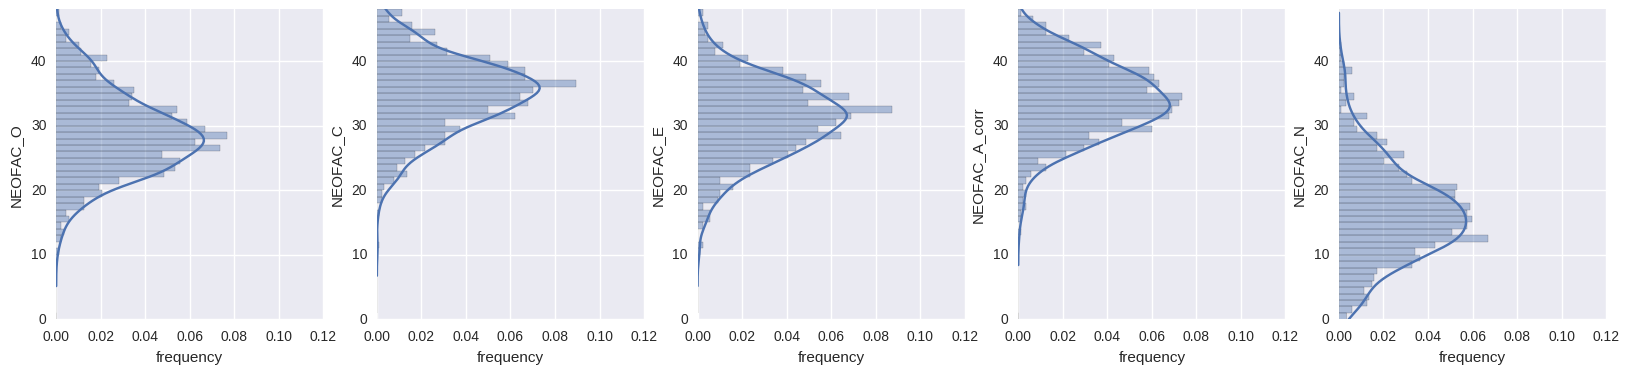

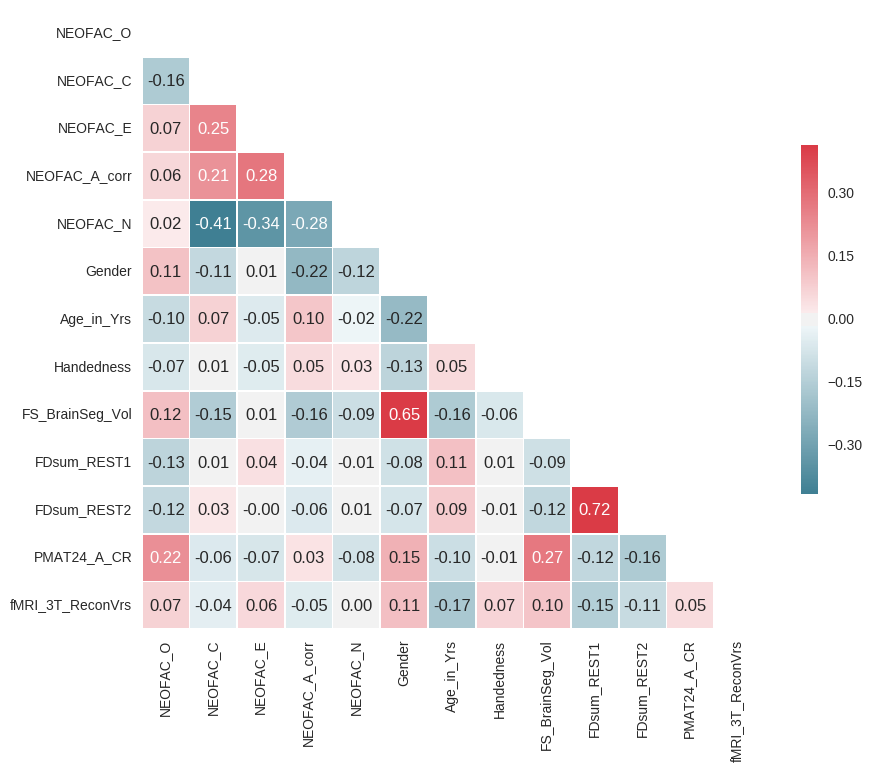

In [12]:
resultsDir = op.join(config.DATADIR,'Results','PERSONALITY')

dataFile   = op.join(resultsDir,'A','Glasser','df.csv')
df = pd.read_csv(dataFile)

scoreL  = ['NEOFAC_O', 'NEOFAC_C', 'NEOFAC_E', 'NEOFAC_A_corr', 'NEOFAC_N']
scoreMat = None
for score in scoreL:
    # add to conMat
    if scoreMat is None:
        scoreMat = np.ravel(df[score])
    else:
        scoreMat = np.vstack((scoreMat,np.ravel(df[score])))

# SHOW DISTRIBUTIONS
fig = plt.figure(figsize=(20,4))
for iScore,score in enumerate(scoreL[:5]):
    ax = fig.add_subplot(1,len(scoreL),iScore+1)
    sns.distplot(scoreMat[iScore,:],bins=range(49), vertical=True)
    ax.set(ylim=(0, 48), xlim=(0, .12), ylabel=score,xlabel="frequency")
    sns.despine(left=False, bottom=True)
if exportFigs:
    plt.savefig(op.join(resultsDir,"scoreDist.svg"), format='svg')
    
    
for i1,score1 in enumerate(scoreL):
    for i2,score2 in enumerate(scoreL):
        if i2>i1:
            tmpCorr = stats.pearsonr(np.ravel(df[score1]),np.ravel(df[score2]))
SML    = ['NEOFAC_O', 'NEOFAC_C', 'NEOFAC_E', 'NEOFAC_A_corr', 'NEOFAC_N',
          'Gender','Age_in_Yrs','Handedness','FS_BrainSeg_Vol','FDsum_REST1','FDsum_REST2','PMAT24_A_CR','fMRI_3T_ReconVrs']
thisdf = df[SML].copy()
corr = thisdf.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt=".2f", mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

for iSM,SM in enumerate(SML[0:5]):
    for jSM in range(iSM+1,5):
        tmp = stats.pearsonr(df[SM],df[SML[jSM]])
        print SM, SML[jSM], 'r=',tmp[0], 'p=',tmp[1]        
tmp = stats.pearsonr(df['FDsum_REST1'],df['FDsum_REST2'])
print 'FDsum_REST1', 'FDsum_REST2', 'r=',tmp[0], 'p=',tmp[1]

if exportFigs:
    plt.savefig(op.join(resultsDir,"confounds.svg"), format='svg')

### Figure 3: compare FC mats

In [13]:
parcellations = ['shen2013','Glasser']
scores        = ['PMAT24_A_CR','NEOFAC_O','NEOFAC_C','NEOFAC_E','NEOFAC_A_corr','NEOFAC_N']
release       = 'all+MEG2';
sessions      = ['REST1','REST2']
preprocs      = ['A','B0','C0']

dataFile   = op.join(resultsDir, 'A','Glasser','df.csv')
df        = pd.read_csv(dataFile)
nSubjects = len(df)

fcMatsAll   = {}
for parcellation in parcellations:
    if parcellation == 'shen2013':
        nNodes = 268
    elif parcellation == 'Glasser':
        nNodes = 360
    nEdges = int(nNodes * (nNodes-1) / 2)
    for iPrep in range(len(preprocs)):
        preproc = preprocs[iPrep]
        inDir     = op.join(resultsDir,preproc,parcellation)
        for session in sessions:
            fcMatFile = op.join(inDir, 'fcMats_{}.mat'.format(session))
            if op.isfile(fcMatFile):
                fcMats = sio.loadmat(fcMatFile)
                tmp = np.zeros([nSubjects,nEdges])
                fcMatsAll[','.join([session,parcellation,preproc])] = fcMats['fcMats_Pearson']
            else:
                continue

#### IDENTIFIABILITY (FINGERPRINTING)
Identification success rate, and other statistics related to connectome fingerprinting (Finn et al., 2015; Noble et al., 2017)

In [14]:
allMatch = np.zeros([6,len(parcellations),len(preprocs)])
direction = 1
for iParcel,parcellation in enumerate(parcellations):
    for iPrep,preproc in enumerate(preprocs):
        print parcellation + ',' + preproc + ': Computing correlations'
        tmpAll = np.corrcoef(np.concatenate((fcMatsAll[','.join(['REST1',parcellation,preproc])],fcMatsAll[','.join(['REST2',parcellation,preproc])]),axis=0))
        if direction == 1: # Fingerprinting 1 > 2
            match = np.zeros([nSubjects,5])
            for sub1 in range(nSubjects):
                tmp = tmpAll[sub1,nSubjects:]
                maxi,indmaxi = np.max(tmp), np.argmax(tmp)
                match[sub1,0]  = (indmaxi==sub1)
                match[sub1,1]  = maxi
                match[sub1,2]  = tmp[sub1]
                match[sub1,3]  = np.mean(tmp[np.setdiff1d(np.arange(nSubjects),sub1)])
                match[sub1,4]  = np.max(tmp[np.setdiff1d(np.arange(nSubjects),sub1)])
        elif direction == 2: # Fingerprinting 2 > 1
            match = np.zeros([nSubjects,5])
            for sub2 in range(nSubjects):
                tmp = tmpAll[:nSubjects,nSubjects+sub2]
                maxi,indmaxi = np.max(tmp), np.argmax(tmp)
                match[sub2,0]  = (indmaxi==sub2)
                match[sub2,1]  = maxi
                match[sub2,2]  = tmp[sub2]
                match[sub2,3]  = np.mean(tmp[np.setdiff1d(np.arange(nSubjects),sub2)])
                match[sub2,4]  = np.max(tmp[np.setdiff1d(np.arange(nSubjects),sub2)])
        allMatch[0,iParcel,iPrep] = np.sum(match[:,0])/match.shape[0]
        allMatch[1,iParcel,iPrep] = np.mean(match[np.where(match[:,1]>0),1])
        allMatch[2,iParcel,iPrep] = np.mean(match[:,2])
        allMatch[3,iParcel,iPrep] = np.mean(match[:,3])
        allMatch[4,iParcel,iPrep] = np.min(match[:,2])
        allMatch[5,iParcel,iPrep] = np.max(match[:,4])

shen2013,A: Computing correlations
shen2013,B0: Computing correlations
shen2013,C0: Computing correlations
Glasser,A: Computing correlations
Glasser,B0: Computing correlations
Glasser,C0: Computing correlations


In [42]:
row_labels    = ['ISR', 'Mean Match', 'Mean Within-Sub', 'Mean Between-sub', 'Worst within', 'Best within']
column_labels = ['MNI A', 'MNI B', 'MNI C', 'MSM-All A', 'MSM-All B','MSM-All C']
dispdf = pd.DataFrame(np.round_(allMatch.reshape((6,-1)),2), columns=column_labels, index=row_labels)
dispdf

,MNI A,MNI B,MNI C,MSM-All A,MSM-All B,MSM-All C
ISR,0.87,0.95,0.92,0.89,0.92,0.88
Mean Match,0.74,0.74,0.72,0.83,0.82,0.80
Mean Within-Sub,0.73,0.74,0.72,0.83,0.82,0.79
Mean Between-sub,0.49,0.51,0.49,0.64,0.65,0.61
Worst within,0.28,0.43,0.41,0.42,0.57,0.48
Best within,0.84,0.77,0.79,0.89,0.86,0.87


#### SIMILARITY BETWEEN SUBJECTS
Test-retest of the pairwise similarities (based on Pearson correlation) between all subjects (Geerligs, Rubinov, et al., 2015).

In [16]:
pairwiseSim = {}
for iParcel,parcellation in enumerate(parcellations):
    fcMatSim = np.zeros([len(sessions)*len(preprocs), int(nSubjects*(nSubjects-1)/2)])
    for iSess,session in enumerate(sessions):
        for iPrep,preproc in enumerate(preprocs):
            print parcellation, session, preproc
            fcMat = fcMatsAll[','.join([session,parcellation,preproc])]
            tmp = np.corrcoef(fcMat)
            fcMatSim[iSess*len(preprocs)+iPrep,:] = tmp[np.triu_indices(nSubjects,k=1)]
    pairwiseSim[parcellation] = np.corrcoef(fcMatSim)

shen2013 REST1 A
shen2013 REST1 B0
shen2013 REST1 C0
shen2013 REST2 A
shen2013 REST2 B0
shen2013 REST2 C0
Glasser REST1 A
Glasser REST1 B0
Glasser REST1 C0
Glasser REST2 A
Glasser REST2 B0
Glasser REST2 C0


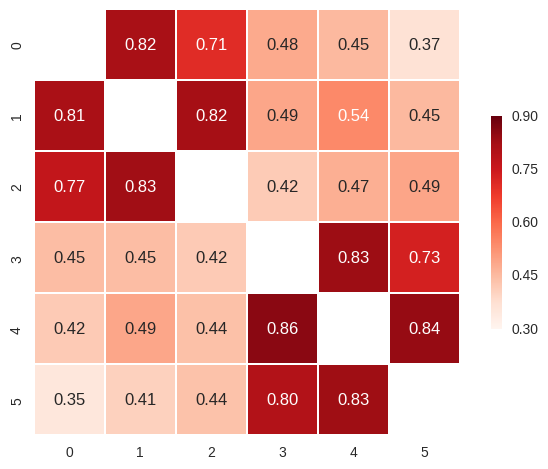

In [17]:
plt.figure()
tmp = np.zeros([len(preprocs)*len(sessions),len(preprocs)*len(sessions)])
tmp[np.triu_indices_from(tmp,k=1)] = pairwiseSim[parcellations[0]][np.triu_indices_from(tmp,k=1)]
tmp[np.tril_indices_from(tmp,k=-1)] = pairwiseSim[parcellations[1]][np.tril_indices_from(tmp,k=-1)]  
mask = np.zeros_like(tmp, dtype=np.bool)
mask[np.diag_indices_from(mask)] = True
sns.heatmap(tmp, annot=True, fmt=".2f", mask=mask,cmap='Reds', vmin=.3,vmax=.9, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
if exportFigs:
    plt.savefig(op.join(resultsDir,"pairwiseSim.svg"), format='svg')

#### Relationship of each edge with behavior
Test-retest reliability of behavioral utility, quantified as the pattern of correlations between each edge and a behavioral score of interest (Geerligs, Rubinov, et al., 2015).

In [18]:
decon_  = 'deconH'
behavUtil   = {}
nChunks     = 50 # chunk correlation computation to avoid RAM overwhelm
for score in scores:
    sys.stdout.write('\n' + score)
    if (decon_=='deconH') and (score not in ['PMAT24_A_CR']):
        decon = decon_+'+IQ'
    else:
        decon = decon_
    
    for parcellation in parcellations:
        if parcellation == 'shen2013':
            nNodes = 268
        elif parcellation == 'Glasser':
            nNodes = 360
        nEdges = int(nNodes * (nNodes-1) / 2)
        # indices for splitting the correlation computation
        chunks = np.array_split(range(nEdges),nChunks)
        fcMatCorr = np.zeros((len(sessions)*len(preprocs),nEdges))
        for iSess,session in enumerate(sessions):
            # make a matrix with just the confounds used
            conMat = None
            for confound in confoundLists[decon]:
                conVec = defConVec(df,confound,session)
                if conMat is None:
                    conMat = np.array(np.ravel(conVec))
                else:
                    conMat = np.vstack((conMat,conVec))
            conMat = conMat.T
            regr = linear_model.LinearRegression()
            regr.fit(conMat, df[score])
            fittedvalues = regr.predict(conMat)
            resid = df[score] - np.ravel(fittedvalues)
            for iPrep,preproc in enumerate(preprocs):
                sys.stdout.write(' .')
                for chunk in chunks: 
                    fcMatCorr[iSess*len(preprocs)+iPrep,chunk] = np.corrcoef(
                        np.concatenate((
                            resid.values.reshape(1,-1),
                            fcMatsAll[','.join([session,parcellation,preproc])][:,chunk].T
                        ),axis=0)
                    )[0,1:]
        behavUtil[','.join([parcellation,score])] = np.corrcoef(fcMatCorr) 


PMAT24_A_CR . . . . . . . . . . . .
NEOFAC_O . . . . . . . . . . . .
NEOFAC_C . . . . . . . . . . . .
NEOFAC_E . . . . . . . . . . . .
NEOFAC_A_corr . . . . . . . . . . . .
NEOFAC_N . . . . . . . . . . . .

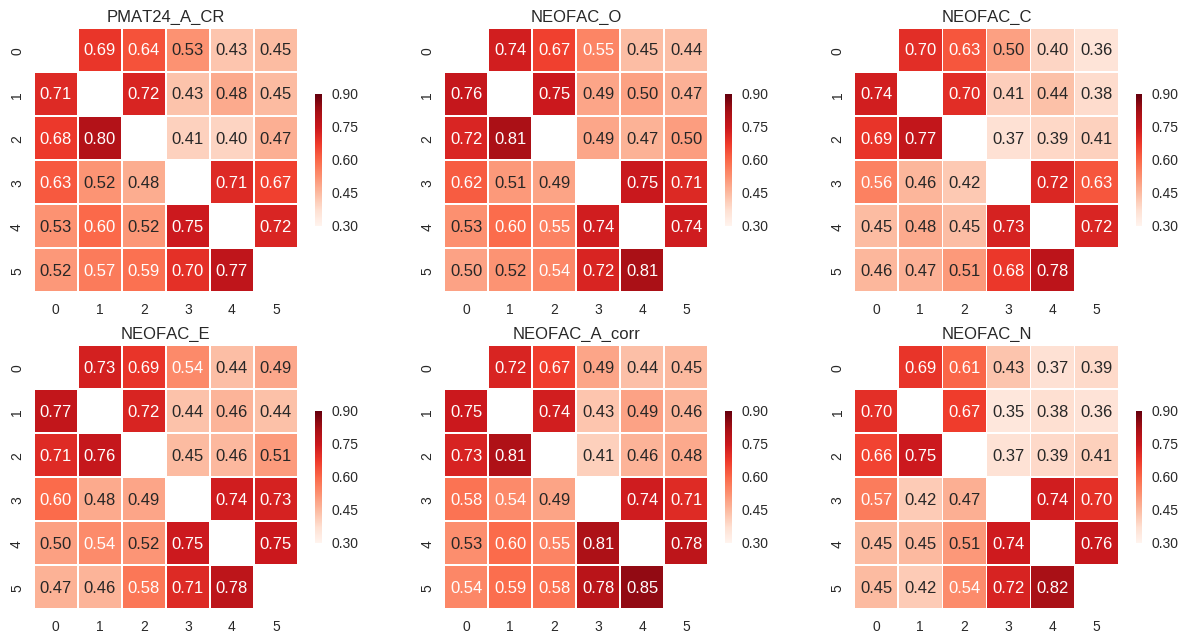

In [19]:
plt.figure(figsize=(15,7.5))
for iScore,score in enumerate(scores):
    plt.subplot(2,len(scores)/2,iScore+1)
    tmp = np.zeros([len(preprocs)*len(sessions),len(preprocs)*len(sessions)])
    tmp[np.triu_indices_from(tmp,k=1)]  = behavUtil[','.join([parcellations[0],score])][np.triu_indices_from(tmp,k=1)]
    tmp[np.tril_indices_from(tmp,k=-1)] = behavUtil[','.join([parcellations[1],score])][np.tril_indices_from(tmp,k=-1)]
    mask = np.zeros_like(tmp, dtype=np.bool)
    mask[np.diag_indices_from(mask)] = True
    sns.heatmap(tmp, annot=True, fmt=".2f", mask=mask,cmap='Reds', vmin=.3,vmax=.9,  
                square=True,linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(score)
if exportFigs:
    plt.savefig(op.join(resultsDir,"behavUtil.svg"), format='svg')

### Figures 4 & 5: plot performance


In [20]:
parcellations = ['shen2013','Glasser']
preprocs      = ['A','B0','C0']
sessions      = ['REST1','REST2']
release       = 'all+MEG2';
scores        = ['PMAT24_A_CR','NEOFAC_O','NEOFAC_C','NEOFAC_E','NEOFAC_A_corr','NEOFAC_N']
predAlgs      = ['Finn','elnet']
fcType        = 'Pearson'
decon_        = 'deconH'
thr           = 0.01
rs   = {}
for parcellation in parcellations:
    if parcellation == 'shen2013':
        nNodes     = 268
    elif parcellation == 'Glasser':
        nNodes     = 360
    nEdges = nNodes * (nNodes-1) / 2
    for predAlg in predAlgs:
        for preproc in preprocs:
            inDir = op.join(resultsDir,preproc,parcellation)
            for score in scores:
                for session in sessions:
                    if (decon_=='deconH') and (score not in ['PMAT24_A_CR']):
                        decon = decon_+'+IQ'
                    else:
                        decon = decon_

                    inDir_ = op.join(inDir,'{}_{}_{}_{}_{}_{}_{}_{}_thr{:.2f}'.format(
                            score,preproc,parcellation,session,decon,fcType,predAlg,release,thr),'0000')
                    try:
                        if predAlg == 'Finn':
                            res0 = sio.loadmat(op.join(inDir_,'result.mat')) 
                            rs[','.join([score,parcellation,preproc,predAlg+'+',session])] = res0['rho_pos']
                            rs[','.join([score,parcellation,preproc,predAlg+'-',session])] = res0['rho_neg']
                            nSub = len(res0['pred_pos'])
                        else:
                            res0 = sio.loadmat(op.join(inDir_,'result.mat')) 
                            rs[','.join([score,parcellation,preproc,predAlg,session])] = res0['rho']
                            nSub = len(res0['pred'])
                    except:
                        print inDir_
                        pass

Correlation between the observed scores (the actual scores of the subjects) and the predicted scores. The correlation obtained using the REST2 dataset was plotted against the correlation from the REST1 dataset, to assess test-retest reliability of the prediction outcome.

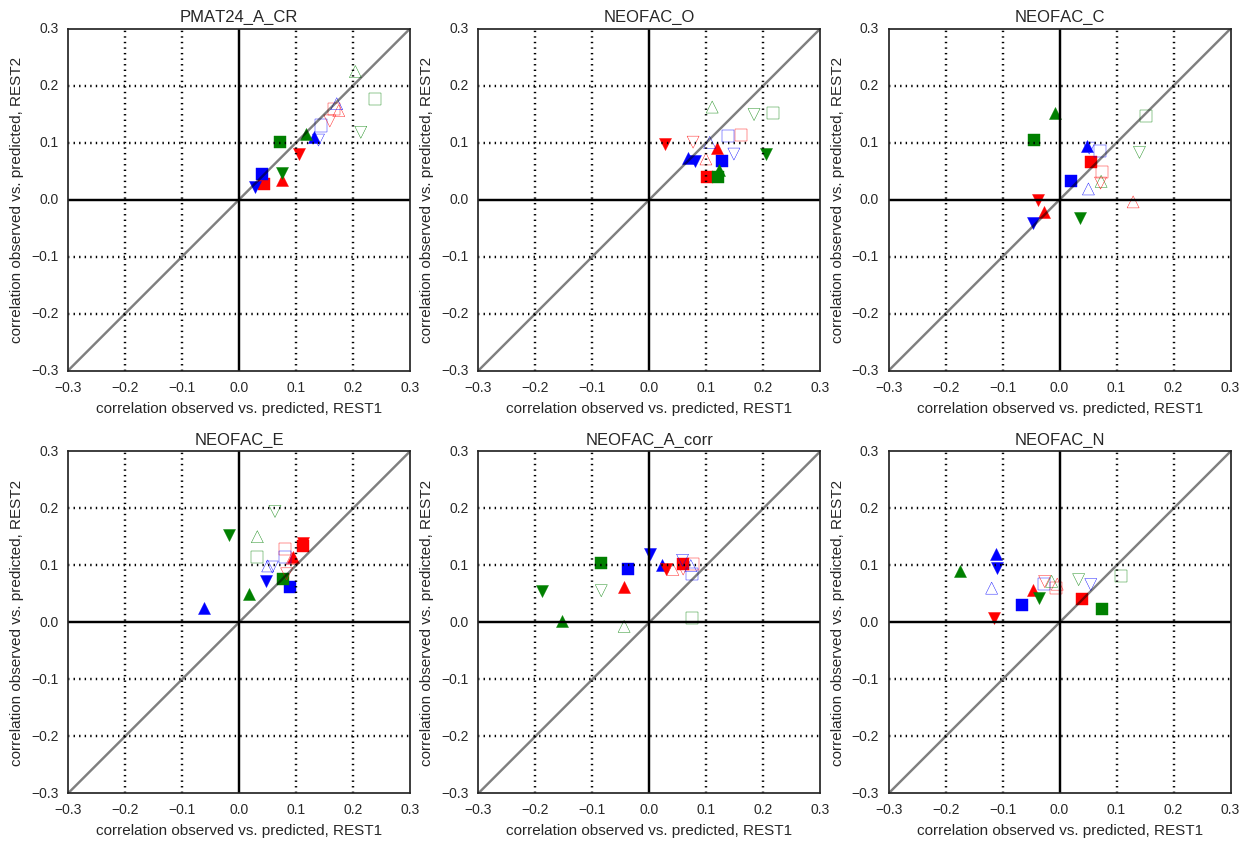

In [21]:
plt.figure(figsize=(15,10))
lim = .3
for iScore,score in enumerate(scores):
    plt.subplot(2,len(scores)/2,iScore+1)
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.set_xlim(lim*np.array([-1,1]))
    ax.set_ylim(lim*np.array([-1,1]))
    ax.axhline(y=0,linestyle='-',color='k')
    ax.axvline(x=0,linestyle='-',color='k')
    ax.hlines([-.2,-.1,.1,.2],-.3,.3,linestyles=':',colors='k')
    ax.vlines([-.2,-.1,.1,.2],-.3,.3,linestyles=':',colors='k')
    # diagonal
    line = plt.Line2D([-lim,lim],[-lim,lim], c='k', linestyle='-',alpha=.5)
    ax.add_line(line)
    # show data
    inLegend = []
    legendEntries = []
    colors = ['blue','red']
    symbols  = ['s','^','v']
    for iParcel,parcellation in enumerate(parcellations):
        for iPrep,preproc in enumerate(preprocs):
            for predAlg in predAlgs:
                if parcellation=='shen2013':
                    if predAlg == 'Finn':
                        h = plt.scatter(rs[','.join([score,parcellation,preproc,predAlg+'+',sessions[0]])],rs[','.join([score,parcellation,preproc,predAlg+'+',sessions[1]])],75,'red',symbols[iPrep],edgecolors='red') 
                        inLegend.append(h)
                        legendEntries.append('{}/{}/{}+'.format(parcellation,preproc,predAlg))
                        h = plt.scatter(rs[','.join([score,parcellation,preproc,predAlg+'-',sessions[0]])],rs[','.join([score,parcellation,preproc,predAlg+'-',sessions[1]])],75,'blue',symbols[iPrep],edgecolors='blue')  
                        inLegend.append(h)
                        legendEntries.append('{}/{}/{}-'.format(parcellation,preproc,predAlg))
                    elif predAlg == 'elnet':
                        h = plt.scatter(rs[','.join([score,parcellation,preproc,predAlg,sessions[0]])],rs[','.join([score,parcellation,preproc,predAlg,sessions[1]])],75,'green',symbols[iPrep],edgecolors='green')  
                        inLegend.append(h)
                        legendEntries.append('{}/{}/{}-'.format(parcellation,preproc,predAlg))
                elif parcellation=='Glasser':
                    if predAlg == 'Finn':
                        h = plt.scatter(rs[','.join([score,parcellation,preproc,predAlg+'+',sessions[0]])],rs[','.join([score,parcellation,preproc,predAlg+'+',sessions[1]])],75,'none',symbols[iPrep],edgecolors='red') 
                        inLegend.append(h)
                        legendEntries.append('{}/{}/{}+'.format(parcellation,preproc,predAlg))
                        h = plt.scatter(rs[','.join([score,parcellation,preproc,predAlg+'-',sessions[0]])],rs[','.join([score,parcellation,preproc,predAlg+'-',sessions[1]])],75,'none',symbols[iPrep],edgecolors='blue')  
                        inLegend.append(h)
                        legendEntries.append('{}/{}/{}-'.format(parcellation,preproc,predAlg))
                    elif predAlg == 'elnet':
                        h = plt.scatter(rs[','.join([score,parcellation,preproc,predAlg,sessions[0]])],rs[','.join([score,parcellation,preproc,predAlg,sessions[1]])],75,'none',symbols[iPrep],edgecolors='green')  
                        inLegend.append(h)
                        legendEntries.append('{}/{}/{}-'.format(parcellation,preproc,predAlg))
    #     if iScore == 0:
    #         plt.legend(inLegend, legendEntries, loc=4)
    plt.xlabel('correlation observed vs. predicted, REST1')
    plt.ylabel('correlation observed vs. predicted, REST2')  
    plt.title(score)
    
if exportFigs:
    plt.savefig(op.join(resultsDir,"test_retest_"+decon_+".svg"), format='svg')

<img src="fig4_legend.png" alt="Figure 4 legend" title="Figure 4 legend" width="300px" />


Pearson correlation coefficients between predicted and observed individual scores, for all behavioral scores and analytical alternatives, on the two sessions.

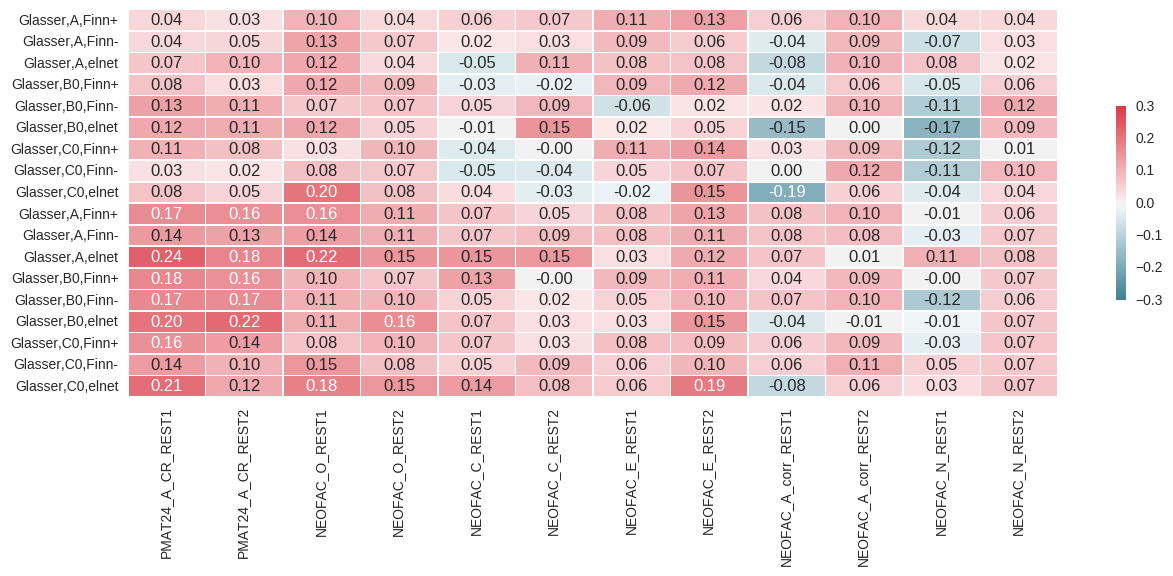

In [22]:
predAlgs = ['Finn+','Finn-','elnet']
tmpL2 = list()
for parcellation in parcellations:
    for preproc in preprocs:
        for predAlg in predAlgs:
            tmpL = list()
            for score in scores:
                for session in sessions:
                    tmpL.append(rs[','.join([score,parcellation,preproc,predAlg,session])][0][0])
            tmpL2.append(tmpL)
resArray = np.asarray(tmpL2) 

fig  = plt.figure(figsize=(15,5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(resArray, annot=True, fmt=".2f", cmap=cmap, vmin=-.3,vmax=.3,
            square=False,linewidths=.5, cbar_kws={"shrink": .5},
            xticklabels=[score+'_'+session for score in scores for session in sessions],
            yticklabels=[parcellation+','+preproc+','+predAlg for parcellations in parcellations for preproc in preprocs for predAlg in predAlgs],
           )
if exportFigs:
    plt.savefig(op.join(resultsDir,"table1_"+decon_+".svg"), format='svg')

### SHOW PERFORMANCE WITH REST12 (with permutation statistics)
only for Glasser, A

In [23]:
# PARAMETRIC STATISTICS FOR CORRELATION
r      = np.linspace(-1, 1, 2000)
t      = r * np.sqrt((len(df['Subject'])-2)/(1-r**2))
p2     = 2 * (1-stats.t.cdf(np.abs(t),len(df['Subject'])-2))
th05   = [r[np.where(p2>=0.025)[0][0]],r[np.where(p2>=0.025)[0][-1]]]
th01   = [r[np.where(p2>=0.005)[0][0]],r[np.where(p2>=0.005)[0][-1]]]
th001  = [r[np.where(p2>=0.0005)[0][0]],r[np.where(p2>=0.0005)[0][-1]]]
thThr  = np.vstack((th05, th01, th001))
print thThr[0]

[-0.07453727  0.07453727]


/hpc/home/duboisjx/software/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()


## PMAT24_A_CR

Prediction results for de-confounded fluid intelligence (PMAT24_A_CR) for the univariate (top figures) and multivariate model (bottom figures). The blue line shows the best fit to the cloud of points (its slope should be close to 1 (dotted line) for good predictions (Piñeiro et al., 2008)). 

The distribution of chance for the prediction score under was estimated using 1000 random permutations of the subjects’ fluid intelligence scores. The distribution of prediction scores under the null hypothesis is shown (black histograms) while the predicted score is shown as a red line. Empirical thresholds are shown in shades of grey. For reference also parametric statistics thresholds are shown (dotted green lines).

In [24]:
resultsDir = op.join(config.DATADIR,'Results','PERSONALITY')
config.pipelineName     = 'A'
config.parcellationName = 'Glasser'

outDir = op.join(resultsDir,config.pipelineName,config.parcellationName)
dataFile = op.join(outDir,'df.csv')
df = pd.read_csv(dataFile)

scores        = ['PMAT24_A_CR']

nPerm = 1000
#----------------------
# predict!
#----------------------
config.queue     = True
launchSubproc    = False
config.sgeopts   = '-l mem_free=2G -tc 100' 
config.overwrite = False
filterThr        = .01
decon_           = 'deconH'
                            
for session in ['REST12']:
    fcMatFile   =  op.join(outDir,'fcMats_'+session+'.mat')
    for fctype in ['Pearson']:#,'invPearson']:
        print ('{}, nsub{}, {}, {}, {}, {}'.format(
            config.release,df.shape[0],config.pipelineName,config.parcellationName,session,fctype))
        for model in ['Finn','elnet']:
            print '> {} thr{:.2f}'.format(model,filterThr)
            for score in scores:
                print '--------> '+ score
                if (decon_ in ['decon','deconH']) and (score not in ['PMAT24_A_CR']):
                    decon = decon_+'+IQ'
                else:
                    decon = decon_

                thisOutDir = op.join(outDir,'{}_{}_{}_{}_{}_{}_{}_{}_thr{:.2f}'.format(
                    score,config.pipelineName,config.parcellationName, session, decon, fctype, model, config.release,filterThr))
                if not op.isdir(thisOutDir):
                    mkdir(thisOutDir)
                # REAL & PERMUTED PREDICTIONS
                jPerm = list()
                print 'Checking existing results'
                printProgressBar(0, nPerm, prefix = 'Progress:', suffix = 'Complete', length = 50)
                for thisPerm in range(nPerm+1): 
                    thisOutDir_ = op.join(thisOutDir,'{0:04d}'.format(thisPerm))
                    if not op.isdir(thisOutDir_):
                        mkdir(thisOutDir_)
                    resFile    = op.join(thisOutDir_,'result.mat')
                    if (not op.isfile(resFile)) or config.overwrite:
                        jPerm.append(thisPerm)
                    printProgressBar(thisPerm, nPerm, prefix = 'Progress:', suffix = 'Complete', length = 50)
                    
                if len(jPerm)>0:
                    print 'Computing missing results'
                    # run this thrice, just in case some jobs fail -- it happens
                    for rep in range(3):
                        runPredictionParJD(fcMatFile,dataFile,SM=score,model=model,session=session,decon=decon,fctype=fctype,
                                           outDir=thisOutDir,confounds=confoundLists[decon],filterThr=filterThr,iPerm=jPerm)
                        checkProgress(pause=10,verbose=False)
                        
                    # merge cross-validation folds, save results
                    print 'Merging CV folds for each permutation'
                    printProgressBar(0, nPerm, prefix = 'Progress:', suffix = 'Complete', length = 50)
                    for thisPerm in jPerm:
                        thisOutDir_ = op.join(thisOutDir,'{0:04d}'.format(thisPerm))
                        resFile     = op.join(thisOutDir_,'result.mat') 
                        if (not op.isfile(resFile)) or config.overwrite:
                            predictions_posneg = np.zeros([df.shape[0],1])
                            predictions_pos    = np.zeros([df.shape[0],1])
                            predictions_neg    = np.zeros([df.shape[0],1])
                            obs                = np.zeros([df.shape[0],1])
                            for el in np.unique(df['Family_ID']):
                                test_index    = list(df.ix[df['Family_ID']==el].index)
                                test_subjects = list(df.ix[df['Family_ID']==el]['Subject'])
                                cvResFile = op.join(thisOutDir_, '{}.mat'.format(
                                    '_'.join(['%s' % test_sub for test_sub in test_subjects])))
                                results = sio.loadmat(cvResFile) 
                                if model=='Finn':
                                    predictions_posneg[test_index] = results['pred_posneg'].T
                                    predictions_pos[test_index]    = results['pred_pos'].T
                                    predictions_neg[test_index]    = results['pred_neg'].T
                                else:
                                    predictions_pos[test_index]    = results['pred'].T
                                obs[test_index]                    = results['score'].T

                            if model=='Finn':
                                rho_posneg,p_posneg   = stats.pearsonr(np.ravel(predictions_posneg),np.ravel(obs))
                                rho_pos,p_pos         = stats.pearsonr(np.ravel(predictions_pos),np.ravel(obs))
                                rho_neg,p_neg         = stats.pearsonr(np.ravel(predictions_neg),np.ravel(obs))
                                results = {'obs':obs,
                                           'pred_posneg':predictions_posneg, 'rho_posneg':rho_posneg, 'p_posneg': p_posneg,
                                           'pred_pos':predictions_pos, 'rho_pos':rho_pos, 'p_pos': p_pos,
                                           'pred_neg':predictions_neg, 'rho_neg':rho_neg, 'p_neg': p_neg}
                            else:
                                rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.ravel(obs))
                                results = {'obs':obs,
                                           'pred':predictions_pos, 'rho':rho, 'p': p}
                            # save result
                            sio.savemat(resFile,results)
                        printProgressBar(thisPerm, nPerm, prefix = 'Progress:', suffix = 'Complete', length = 50)

all+MEG2, nsub884, A, Glasser, REST12, Pearson
> Finn thr0.01
--------> PMAT24_A_CR
Checking existing results
Progress: |##################################################| 100.0% Complete()
> elnet thr0.01
--------> PMAT24_A_CR
Checking existing results
Progress: |##################################################| 100.0% Complete()


Finn
Pearson r=0.216
R-squared=0.007
nRMSD    =0.997
elnet
Pearson r=0.259
R-squared=0.044
nRMSD    =0.978


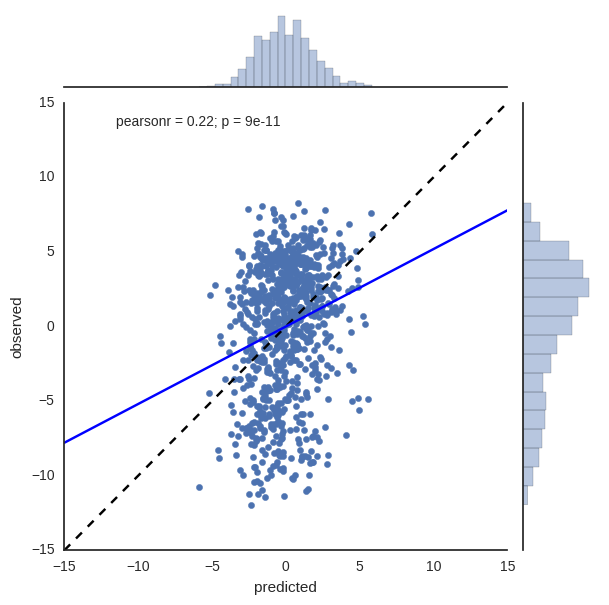

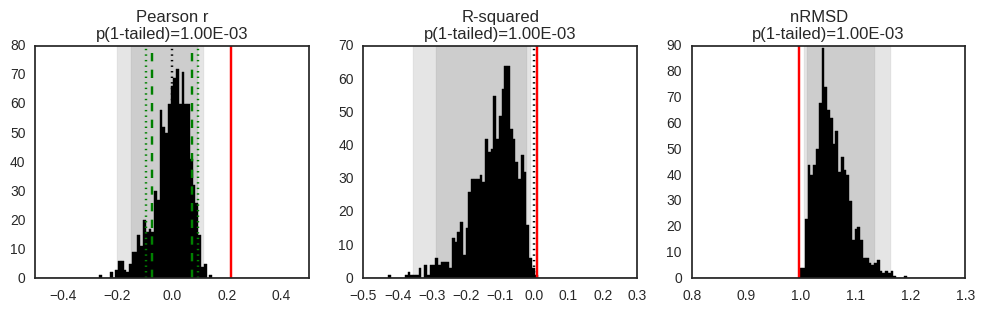

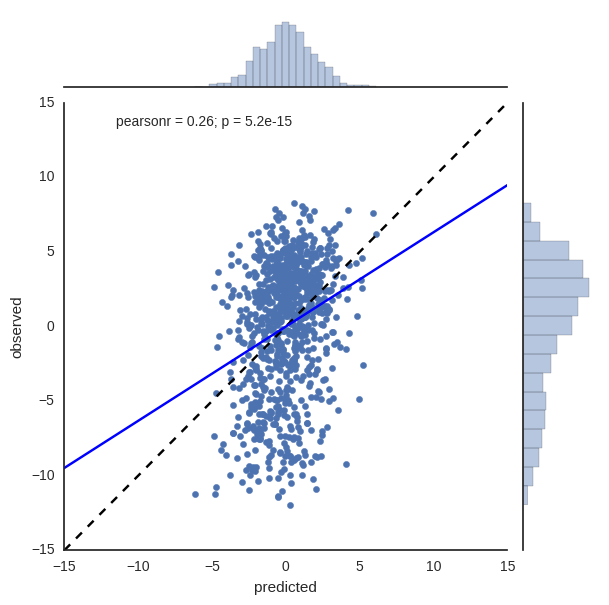

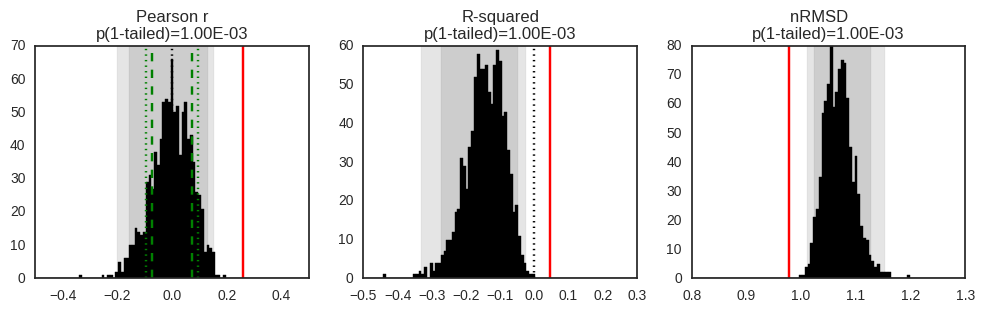

In [25]:
nPerm     = 1000
session   = 'REST12'
fctype    = 'Pearson'
models    = ['Finn','elnet']
plotPos   = True # plot positive or negative univariate model results
filterThr = .01
decon_    = 'deconH'

for iScore, score in enumerate(scores):
    
    for iModel, model in enumerate(models):
        print model
        if (decon_ in ['decon','deconH']) and (score not in ['PMAT24_A_CR']):
            decon = decon_+'+IQ'
        else:
            decon = decon_

        
        thisOutDir = op.join(outDir,'{}_{}_{}_{}_{}_{}_{}_{}_thr{:.2f}'.format(
                        score,config.pipelineName,config.parcellationName, session, 
                        decon, fctype, model, config.release,filterThr))

        outFileStats = op.join(thisOutDir,'fitStats.mat')

        if not op.isfile(outFileStats):
            fitMeas      = ['Pearson r','R-squared','nRMSD']
            fitPerm      = np.empty([nPerm+1,3])
            fitPerm[:]   = np.nan
            if model == 'Finn':
                fitPermN      = np.empty([nPerm+1,3])
                fitPermN[:]   = np.nan
            if nPerm>0:
                printProgressBar(0, nPerm, prefix = 'Progress:', suffix = 'Complete', length = 50)
            for thisPerm in range(nPerm+1):
                resDir    = op.join(thisOutDir,'{0:04d}'.format(thisPerm))
                ## MAKE SURE RESULTS.MAT EXISTS, AND HAS OBSERVED DATA SAVED
                resFile   = op.join(resDir,'result.mat')
                rePackage = False
                if (not op.isfile(resFile)) or config.overwrite:
                    rePackage = True
                else:
                    res       = sio.loadmat(resFile)
                    if 'obs' not in res.keys():
                        rePackage = True
                if rePackage: 
                    # merge cross-validation folds, save results
                    obs              = np.zeros([df.shape[0],1])
                    pred             = np.zeros([df.shape[0],1])
                    for el in np.unique(df['Family_ID']):
                        test_index    = list(df.ix[df['Family_ID']==el].index)
                        test_subjects = list(df.ix[df['Family_ID']==el]['Subject'])
                        cvResFile = op.join(resDir,'{}.mat'.format(
                            '_'.join(['%s' % test_sub for test_sub in test_subjects])))
                        try:
                            results = sio.loadmat(cvResFile) 
                        except:
                            print 'Missing prediction!'+cvResFile

                        if model == 'Finn':
                            pred_pos[test_index]    = results['pred_pos'].T
                            pred_neg[test_index]    = results['pred_neg'].T
                            pred_posneg[test_index] = results['pred_posneg'].T
                        else:
                            pred[test_index] = results['pred'].T
                        obs[test_index]      = results['score'].T

                    if model=='Finn':
                        rho_posneg,p_posneg   = stats.pearsonr(np.ravel(pred_posneg),np.ravel(obs))
                        rho_pos,p_pos         = stats.pearsonr(np.ravel(pred_pos),np.ravel(obs))
                        rho_neg,p_neg         = stats.pearsonr(np.ravel(pred_neg),np.ravel(obs))
                        res = {'obs':obs,
                                   'pred_posneg':pred_posneg, 'rho_posneg':rho_posneg, 'p_posneg': p_posneg,
                                   'pred_pos':pred_pos, 'rho_pos':rho_pos, 'p_pos': p_pos,
                                   'pred_neg':pred_neg, 'rho_neg':rho_neg, 'p_neg': p_neg}
                    else:
                        rho,p   = stats.pearsonr(np.ravel(pred),np.ravel(obs))
                        res = {'obs':obs,
                                   'pred':pred, 'rho':rho, 'p': p}
                    # save result
                    sio.savemat(resFile,res)
                else:
                    res       = sio.loadmat(resFile)

                if model == 'Finn': 
                    obs  = res['obs'].reshape(-1,)
                    #--> positive model
                    pred = res['pred_pos'].reshape(-1,)
                    fitPerm[thisPerm,0] = stats.pearsonr(obs,pred)[0]
                    # compute R^2
                    fitPerm[thisPerm,1] = 1 - np.sum(np.square(obs-pred)) / np.sum(np.square(obs-np.mean(obs)))
                    # compute nRMSD = sqrt(1-R^2)
                    fitPerm[thisPerm,2] = np.sqrt(1 - fitPerm[thisPerm,1])
                    #--> negative model
                    predN = res['pred_neg'].reshape(-1,)
                    fitPermN[thisPerm,0] = stats.pearsonr(obs,predN)[0]
                    # compute R^2
                    fitPermN[thisPerm,1] = 1 - np.sum(np.square(obs-predN)) / np.sum(np.square(obs-np.mean(obs)))
                    # compute nRMSD = sqrt(1-R^2)
                    fitPermN[thisPerm,2] = np.sqrt(1 - fitPermN[thisPerm,1])
                    
                else:
                    pred = res['pred'].reshape(-1,)
                    obs  = res['obs'].reshape(-1,)
                    fitPerm[thisPerm,0] = stats.pearsonr(obs,pred)[0]
                    # compute R^2
                    fitPerm[thisPerm,1] = 1 - np.sum(np.square(obs-pred)) / np.sum(np.square(obs-np.mean(obs)))
                    # compute nRMSD = sqrt(1-R^2)
                    fitPerm[thisPerm,2] = np.sqrt(1 - fitPerm[thisPerm,1])
                if nPerm>0:
                    printProgressBar(thisPerm, nPerm, prefix = 'Progress:', suffix = 'Complete', length = 50)               
            #save fitPerm
            res = {'fitPerm':fitPerm,'fitPermN':fitPermN,'fitMeas':fitMeas}
            # save result
            sio.savemat(outFileStats,res)
        else:
            res     = sio.loadmat(outFileStats)
            fitPerm = res['fitPerm']
            fitMeas = res['fitMeas']
            if model == 'Finn' and not plotPos:
                fitPerm = res['fitPermN']


        resFile   = op.join(thisOutDir,'0000','result.mat')
        res       = sio.loadmat(resFile)
        if model == 'Finn': 
            if plotPos:
                pred0 = res['pred_pos'].reshape(-1,)
            else:
                pred0 = res['pred_neg'].reshape(-1,)
            obs0  = res['obs'].reshape(-1,)
        else:
            pred0 = res['pred'].reshape(-1,)
            obs0  = res['obs'].reshape(-1,)

        # plot three fit measures and their null distributions
        nSub  = len(pred0)

        # PLOT OBSERVED vs. PREDICTED (cf. Pineiro et al, Ecological Modeling 2008)
        g  = sns.jointplot(pred0,obs0)
        # adjust the axes
        lims = [-15,15]
        g.ax_joint.set_xlim(lims)
        g.ax_joint.set_ylim(lims)
        g.ax_joint.set_xlabel('predicted')
        g.ax_joint.set_ylabel('observed')
        # PLOT THE 1:1 line
        line = plt.Line2D(lims,lims, c='k', linestyle='--')
        g.ax_joint.add_line(line)
        # FIT REGRESSION LINE
        regr = linear_model.LinearRegression()
        regr.fit(pred0.reshape(-1,1), obs0.reshape(-1,1))
        line = plt.Line2D(np.array(lims).reshape(-1,1),regr.predict(np.array(lims).reshape(-1,1)), c='b', linestyle='-')
        g.ax_joint.add_line(line)
        if exportFigs:
            plt.savefig(op.join(resultsDir,"{}_{}_{}_obsVSpred.svg".format(score,model,decon)), format='svg')

        f, ax = plt.subplots(1, 3, sharey=False,figsize=(12,3))
        for i,meas in enumerate(fitMeas):
            if meas=='Pearson r':
                lims = [-.5,.5]
            elif meas=='R-squared':
                lims = [-.5,.3]
            elif meas[0:5]=='nRMSD':
                lims = [0.8,1.3]
            print '{}={:.3f}'.format(meas,fitPerm[0,i])
            if nPerm>0:
                xs       = np.linspace(lims[0],lims[1],100)
                empThr05 = [np.percentile(fitPerm[1:,i],[2.5, 97.5],interpolation='midpoint')]
                empThr01 = [np.percentile(fitPerm[1:,i],[.5, 99.5],interpolation='midpoint')]
                empThr   = np.vstack((empThr05, empThr01))
                Ns, bins = np.histogram(fitPerm[1:,i], xs)
                ax[i].hist(fitPerm[1:,i], bins,color='k')
                v        = ax[i].get_ylim()
                ax[i].fill(np.hstack([empThr[1,:], empThr[1,::-1]]),[v[0], v[0], v[1], v[1]],'k',alpha=0.1)
                ax[i].fill(np.hstack([empThr[0,:], empThr[0,::-1]]),[v[0], v[0], v[1], v[1]],'k',alpha=0.1)
                # true
                line = plt.Line2D([fitPerm[0,i],fitPerm[0,i]],[v[0],v[1]], c='r', linestyle='-')
                ax[i].add_line(line)
                ax[i].axvline(x=0,color='k',linestyle=':')
                if i==0:
                    ax[i].vlines(x=thThr[0],ymin=v[0],ymax=v[1],linestyles='--',colors='g')
                    ax[i].vlines(x=thThr[1],ymin=v[0],ymax=v[1],linestyles=':',colors='g')
                ax[i].set_xlim(lims)
                if meas in ['Pearson r','R-squared']:
                    p = ((nPerm-np.where(np.argsort(np.ravel(fitPerm[:,i]))==0)[0][0])+1)/np.float(nPerm)
                else:
                    p = ((np.where(np.argsort(np.ravel(fitPerm[:,i]))==0)[0][0])+1)/np.float(nPerm)
                ax[i].set_title('{}\np(1-tailed)={:.2E}'.format(fitMeas[i],p))

        if exportFigs:
            plt.savefig(op.join(resultsDir,"{}_{}_{}_predStats.svg".format(score,model,decon)), format='svg')

## personality scores

In [26]:
resultsDir = op.join(config.DATADIR,'Results','PERSONALITY')
config.pipelineName     = 'A'
config.parcellationName = 'Glasser'

outDir = op.join(resultsDir,config.pipelineName,config.parcellationName)
dataFile = op.join(outDir,'df.csv')
df = pd.read_csv(dataFile)

scores        = ['NEOFAC_O','NEOFAC_C','NEOFAC_E','NEOFAC_A_corr','NEOFAC_N']#

nPerm = 1000
#----------------------
# predict!
#----------------------
config.queue     = True
launchSubproc    = False
config.sgeopts   = '-l mem_free=1G -tc 100' 
config.overwrite = False
filterThr        = .01
decon_           = 'deconH'
                            
for session in ['REST12']:
    fcMatFile   =  op.join(outDir,'fcMats_'+session+'.mat')
    for fctype in ['Pearson']:#,'invPearson']:
        print ('{}, nsub{}, {}, {}, {}, {}'.format(
            config.release,df.shape[0],config.pipelineName,config.parcellationName,session,fctype))
        for model in ['elnet']:#'Finn'
            print '> {} thr{:.2f}'.format(model,filterThr)
            for score in scores:
                print '--------> '+ score
                if (decon_ in ['decon','deconH']) and (score not in ['PMAT24_A_CR']):
                    decon = decon_+'+IQ'
                else:
                    decon = decon_

                thisOutDir = op.join(outDir,'{}_{}_{}_{}_{}_{}_{}_{}_thr{:.2f}'.format(
                    score,config.pipelineName,config.parcellationName, session, decon, fctype, model, config.release,filterThr))
                if not op.isdir(thisOutDir):
                    mkdir(thisOutDir)
                # REAL & PERMUTED PREDICTIONS
                jPerm = list()
                print 'Checking existing results'
                printProgressBar(0, nPerm, prefix = 'Progress:', suffix = 'Complete', length = 50)
                for thisPerm in range(nPerm+1): 
                    thisOutDir_ = op.join(thisOutDir,'{0:04d}'.format(thisPerm))
                    if not op.isdir(thisOutDir_):
                        mkdir(thisOutDir_)
                    resFile    = op.join(thisOutDir_,'result.mat')
                    if (not op.isfile(resFile)) or config.overwrite:
                        jPerm.append(thisPerm)
                    printProgressBar(thisPerm, nPerm, prefix = 'Progress:', suffix = 'Complete', length = 50)
                    
                if len(jPerm)>0:
                    print 'Computing missing results'
                    # run this thrice, just in case some jobs fail -- it happens
                    for rep in range(3):
                        runPredictionParJD(fcMatFile,dataFile,SM=score,model=model,session=session,decon=decon,fctype=fctype,
                                           outDir=thisOutDir,confounds=confoundLists[decon],filterThr=filterThr,iPerm=jPerm)
                        checkProgress(pause=10,verbose=False)
                        
                    # merge cross-validation folds, save results
                    print 'Merging CV folds for each permutation'
                    printProgressBar(0, nPerm, prefix = 'Progress:', suffix = 'Complete', length = 50)
                    for thisPerm in jPerm:
                        thisOutDir_ = op.join(thisOutDir,'{0:04d}'.format(thisPerm))
                        resFile     = op.join(thisOutDir_,'result.mat') 
                        if (not op.isfile(resFile)) or config.overwrite:
                            predictions_posneg = np.zeros([df.shape[0],1])
                            predictions_pos    = np.zeros([df.shape[0],1])
                            predictions_neg    = np.zeros([df.shape[0],1])
                            obs                = np.zeros([df.shape[0],1])
                            for el in np.unique(df['Family_ID']):
                                test_index    = list(df.ix[df['Family_ID']==el].index)
                                test_subjects = list(df.ix[df['Family_ID']==el]['Subject'])
                                cvResFile = op.join(thisOutDir_, '{}.mat'.format(
                                    '_'.join(['%s' % test_sub for test_sub in test_subjects])))
                                results = sio.loadmat(cvResFile) 
                                if model=='Finn':
                                    predictions_posneg[test_index] = results['pred_posneg'].T
                                    predictions_pos[test_index]    = results['pred_pos'].T
                                    predictions_neg[test_index]    = results['pred_neg'].T
                                else:
                                    predictions_pos[test_index]    = results['pred'].T
                                obs[test_index]                    = results['score'].T

                            if model=='Finn':
                                rho_posneg,p_posneg   = stats.pearsonr(np.ravel(predictions_posneg),np.ravel(obs))
                                rho_pos,p_pos         = stats.pearsonr(np.ravel(predictions_pos),np.ravel(obs))
                                rho_neg,p_neg         = stats.pearsonr(np.ravel(predictions_neg),np.ravel(obs))
                                results = {'obs':obs,
                                           'pred_posneg':predictions_posneg, 'rho_posneg':rho_posneg, 'p_posneg': p_posneg,
                                           'pred_pos':predictions_pos, 'rho_pos':rho_pos, 'p_pos': p_pos,
                                           'pred_neg':predictions_neg, 'rho_neg':rho_neg, 'p_neg': p_neg}
                            else:
                                rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.ravel(obs))
                                results = {'obs':obs,
                                           'pred':predictions_pos, 'rho':rho, 'p': p}
                            # save result
                            sio.savemat(resFile,results)
                        printProgressBar(thisPerm, nPerm, prefix = 'Progress:', suffix = 'Complete', length = 50)

all+MEG2, nsub884, A, Glasser, REST12, Pearson
> elnet thr0.01
--------> NEOFAC_O
Checking existing results
Progress: |##################################################| 100.0% Complete()
--------> NEOFAC_C
Checking existing results
Progress: |##################################################| 100.0% Complete()
--------> NEOFAC_E
Checking existing results
Progress: |##################################################| 100.0% Complete()
--------> NEOFAC_A_corr
Checking existing results
Progress: |##################################################| 100.0% Complete()
--------> NEOFAC_N
Checking existing results
Progress: |##################################################| 100.0% Complete()


NEOFAC_O
Pearson r=0.238
R-squared=0.024
nRMSD    =0.988
NEOFAC_C
Pearson r=0.137
R-squared=-0.056
nRMSD    =1.027
NEOFAC_E
Pearson r=0.092
R-squared=-0.093
nRMSD    =1.045
NEOFAC_A_corr
Pearson r=0.032
R-squared=-0.064
nRMSD    =1.031
NEOFAC_N
Pearson r=0.130
R-squared=-0.055
nRMSD    =1.027


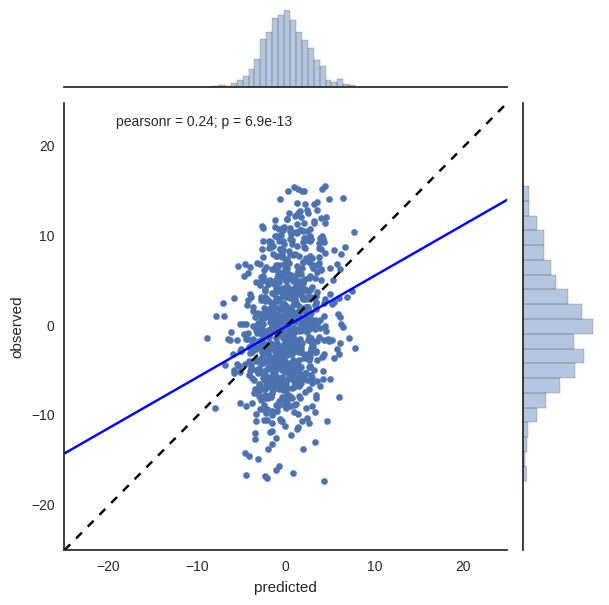

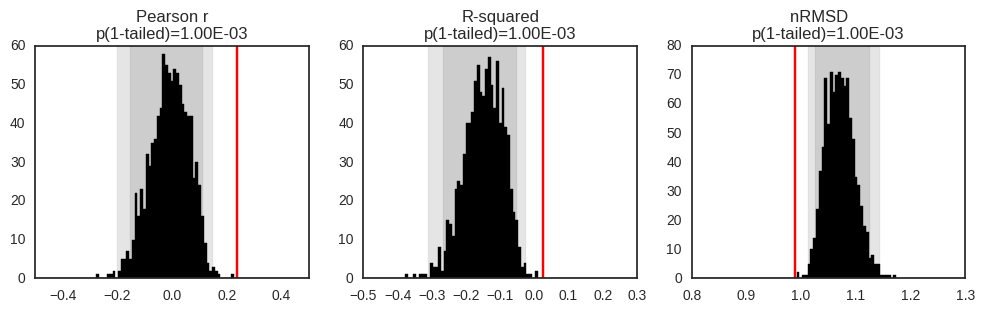

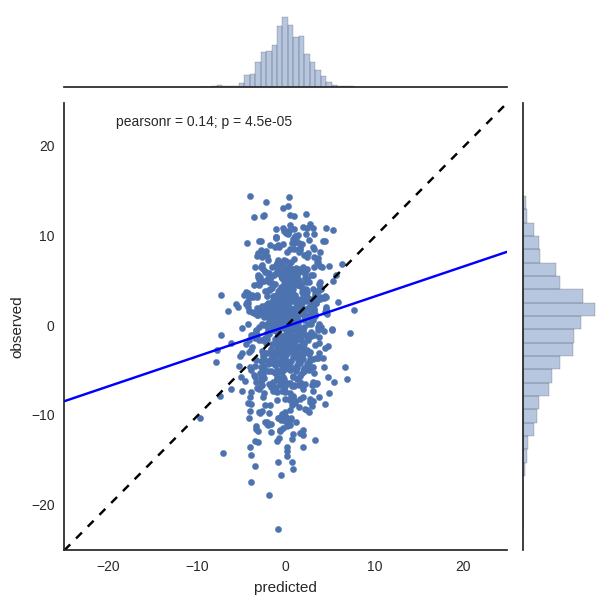

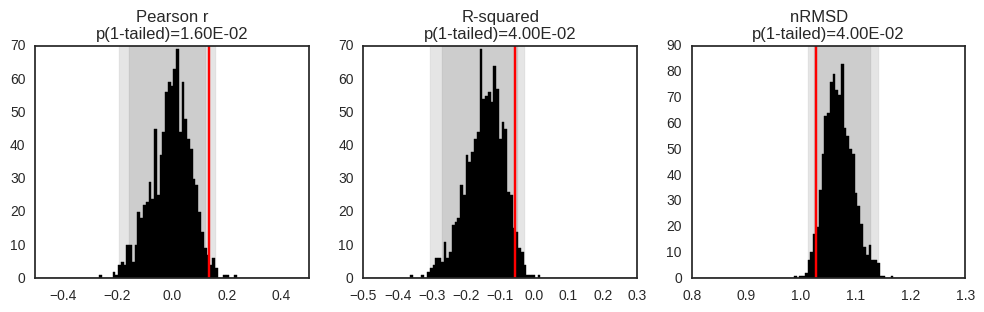

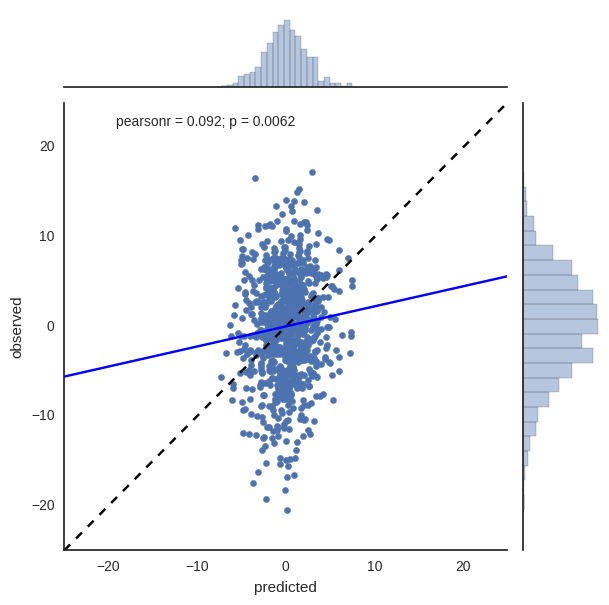

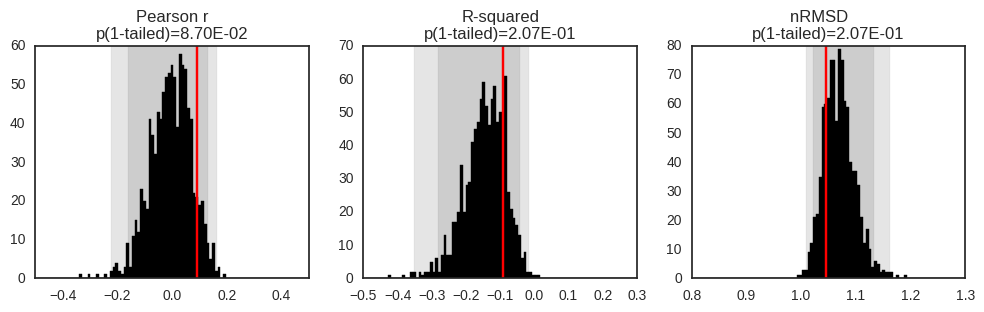

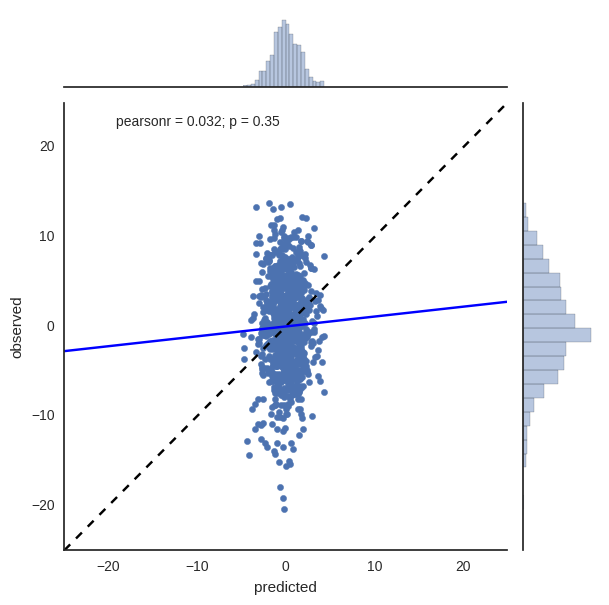

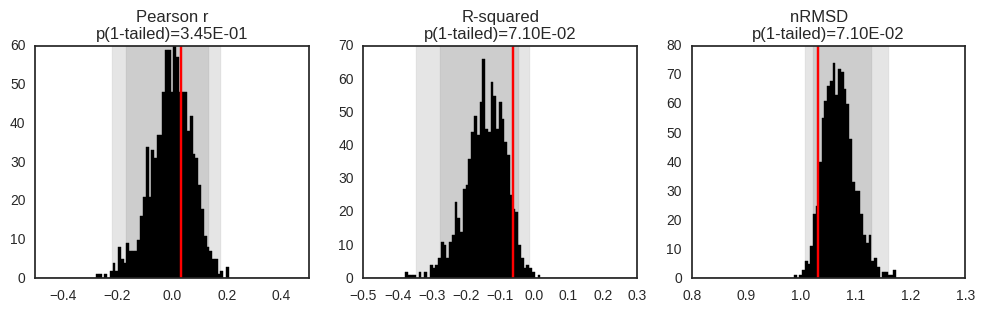

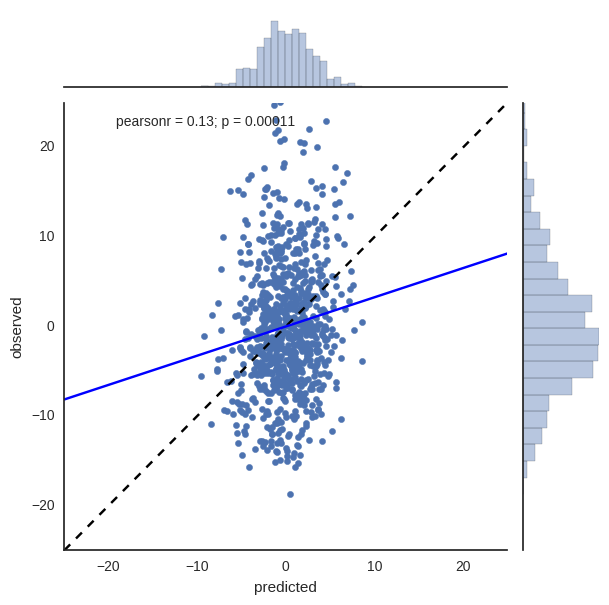

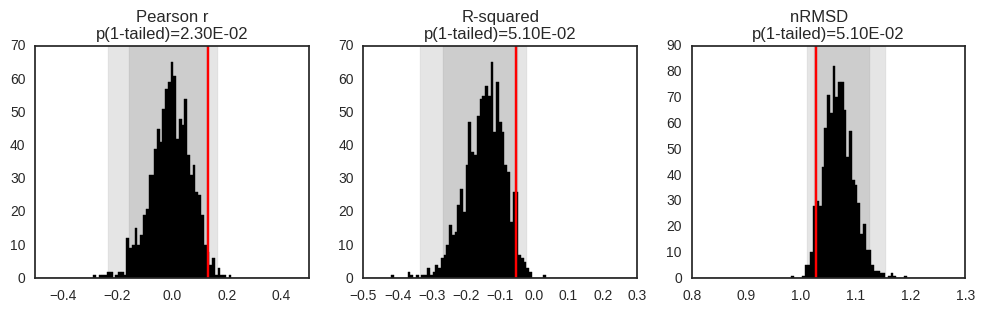

In [27]:
nPerm     = 1000
session   = 'REST12'
fctype    = 'Pearson'
model     = 'elnet'
filterThr = .01
decon_    = 'deconH'

for iScore, score in enumerate(scores):
    if (decon_ in ['decon','deconH']) and (score not in ['PMAT24_A_CR']):
        decon = decon_+'+IQ'
    else:
        decon = decon_

    
    thisOutDir = op.join(outDir,'{}_{}_{}_{}_{}_{}_{}_{}_thr{:.2f}'.format(
                    score,config.pipelineName,config.parcellationName, session, 
                    decon, fctype, model, config.release,filterThr))

    outFileStats = op.join(thisOutDir,'fitStats.mat')

    if not op.isfile(outFileStats):
        fitMeas      = ['Pearson r','R-squared','nRMSD']
        fitPerm      = np.empty([nPerm+1,3])
        fitPerm[:]   = np.nan
        if nPerm>0:
            printProgressBar(0, nPerm, prefix = 'Progress:', suffix = 'Complete', length = 50)
        for thisPerm in range(nPerm+1):
            resDir    = op.join(thisOutDir,'{0:04d}'.format(thisPerm))
            ## MAKE SURE RESULTS.MAT EXISTS, AND HAS OBSERVED DATA SAVED
            resFile   = op.join(resDir,'result.mat')
            rePackage = False
            if (not op.isfile(resFile)) or config.overwrite:
                rePackage = True
            else:
                res       = sio.loadmat(resFile)
                if 'obs' not in res.keys():
                    rePackage = True
            if rePackage: 
                # merge cross-validation folds, save results
                obs              = np.zeros([df.shape[0],1])
                pred             = np.zeros([df.shape[0],1])
                for el in np.unique(df['Family_ID']):
                    test_index    = list(df.ix[df['Family_ID']==el].index)
                    test_subjects = list(df.ix[df['Family_ID']==el]['Subject'])
                    cvResFile = op.join(resDir,'{}.mat'.format(
                        '_'.join(['%s' % test_sub for test_sub in test_subjects])))
                    try:
                        results = sio.loadmat(cvResFile) 
                    except:
                        print 'Missing prediction!'+cvResFile

                    if model=='Finn':
                        pred_pos[test_index]    = results['pred_pos'].T
                        pred_neg[test_index]    = results['pred_neg'].T
                        pred_posneg[test_index] = results['pred_posneg'].T
                    else:
                        pred[test_index] = results['pred'].T
                    obs[test_index]      = results['score'].T

                if model=='Finn':
                    rho_posneg,p_posneg   = stats.pearsonr(np.ravel(pred_posneg),np.ravel(obs))
                    rho_pos,p_pos         = stats.pearsonr(np.ravel(pred_pos),np.ravel(obs))
                    rho_neg,p_neg         = stats.pearsonr(np.ravel(pred_neg),np.ravel(obs))
                    res = {'obs':obs,
                               'pred_posneg':pred_posneg, 'rho_posneg':rho_posneg, 'p_posneg': p_posneg,
                               'pred_pos':pred_pos, 'rho_pos':rho_pos, 'p_pos': p_pos,
                               'pred_neg':pred_neg, 'rho_neg':rho_neg, 'p_neg': p_neg}
                else:
                    rho,p   = stats.pearsonr(np.ravel(pred),np.ravel(obs))
                    res = {'obs':obs,
                               'pred':pred, 'rho':rho, 'p': p}
                # save result
                sio.savemat(resFile,res)
            else:
                res       = sio.loadmat(resFile)

            if model == 'Finn': 
                pred = res['pred_pos'].reshape(-1,)
                obs  = res['obs'].reshape(-1,)
            else:
                pred = res['pred'].reshape(-1,)
                obs  = res['obs'].reshape(-1,)

            fitPerm[thisPerm,0] = stats.pearsonr(obs,pred)[0]
            # compute R^2
            fitPerm[thisPerm,1] = 1 - np.sum(np.square(obs-pred)) / np.sum(np.square(obs-np.mean(obs)))
            # compute nRMSD = sqrt(1-R^2)
            fitPerm[thisPerm,2] = np.sqrt(1 - fitPerm[thisPerm,1])
            if nPerm>0:
                printProgressBar(thisPerm, nPerm, prefix = 'Progress:', suffix = 'Complete', length = 50)               
        #save fitPerm
        res = {'fitPerm':fitPerm,'fitMeas':fitMeas}
        # save result
        sio.savemat(outFileStats,res)
    else:
        res     = sio.loadmat(outFileStats)
        fitPerm = res['fitPerm']
        fitMeas = res['fitMeas']

    
    resFile   = op.join(thisOutDir,'0000','result.mat')
    res       = sio.loadmat(resFile)
    if model == 'Finn': 
        pred0 = res['pred_pos'].reshape(-1,)
        obs0  = res['obs'].reshape(-1,)
    else:
        pred0 = res['pred'].reshape(-1,)
        obs0  = res['obs'].reshape(-1,)

    # plot three fit measures and their null distributions
    nSub  = len(pred0)

    # PLOT OBSERVED vs. PREDICTED (cf. Pineiro et al, Ecological Modeling 2008)
    g  = sns.jointplot(pred0,obs0)
    # adjust the axes
    lims = [-25,25]
    g.ax_joint.set_xlim(lims)
    g.ax_joint.set_ylim(lims)
    g.ax_joint.set_xlabel('predicted')
    g.ax_joint.set_ylabel('observed')
    # PLOT THE 1:1 line
    line = plt.Line2D(lims,lims, c='k', linestyle='--')
    g.ax_joint.add_line(line)
    # FIT REGRESSION LINE
    regr = linear_model.LinearRegression()
    regr.fit(pred0.reshape(-1,1), obs0.reshape(-1,1))
    line = plt.Line2D(np.array(lims).reshape(-1,1),regr.predict(np.array(lims).reshape(-1,1)), c='b', linestyle='-')
    g.ax_joint.add_line(line)
    if exportFigs:
        plt.savefig(op.join(resultsDir,"{}_{}_{}_obsVSpred.svg".format(score,model,decon)), format='svg')


    f, ax = plt.subplots(1, 3, sharey=False,figsize=(12,3))
    print score
    for i,meas in enumerate(fitMeas):
        if meas=='Pearson r':
            lims = [-.5,.5]
        elif meas=='R-squared':
            lims = [-.5,.3]
        elif meas[0:5]=='nRMSD':
            lims = [0.8,1.3]
        print '{}={:.3f}'.format(meas,fitPerm[0,i])
        if nPerm>0:
            xs       = np.linspace(lims[0],lims[1],100)
            empThr05 = [np.percentile(fitPerm[1:,i],[2.5, 97.5],interpolation='midpoint')]
            empThr01 = [np.percentile(fitPerm[1:,i],[.5, 99.5],interpolation='midpoint')]
            empThr   = np.vstack((empThr05, empThr01))
            Ns, bins = np.histogram(fitPerm[1:,i], xs)
            ax[i].hist(fitPerm[1:,i], bins,color='k')
            v        = ax[i].get_ylim()
            ax[i].fill(np.hstack([empThr[1,:], empThr[1,::-1]]),[v[0], v[0], v[1], v[1]],'k',alpha=0.1)
            ax[i].fill(np.hstack([empThr[0,:], empThr[0,::-1]]),[v[0], v[0], v[1], v[1]],'k',alpha=0.1)
            # true
            line = plt.Line2D([fitPerm[0,i],fitPerm[0,i]],[v[0],v[1]], c='r', linestyle='-')
            ax[i].add_line(line)
            ax[i].set_xlim(lims)
            if meas in ['Pearson r','R-squared']:
                p = ((nPerm-np.where(np.argsort(np.ravel(fitPerm[:,i]))==0)[0][0])+1)/np.float(nPerm)
            else:
                p = ((np.where(np.argsort(np.ravel(fitPerm[:,i]))==0)[0][0])+1)/np.float(nPerm)
            ax[i].set_title('{}\np(1-tailed)={:.2E}'.format(fitMeas[i],p))

    if exportFigs:
        plt.savefig(op.join(resultsDir,"{}_{}_{}_predStats.svg".format(score,model,decon)), format='svg')

## Derive superordinate factors alpha & beta

In [28]:
resultsDir = op.join(config.DATADIR,'Results','PERSONALITY')
config.pipelineName     = 'A'
config.parcellationName = 'Glasser'
outDir = op.join(resultsDir,config.pipelineName,config.parcellationName)

dataFile = op.join(outDir,'df.csv')
df = pd.read_csv(dataFile)

In [29]:
standardize = lambda x: (x-x.mean()) / x.std() #* 15. + 100.
NEOitems = [
    'NEOFAC_O','NEOFAC_C','NEOFAC_E','NEOFAC_A_corr','NEOFAC_N',
]
# standardize scores
NEOdf      = df[NEOitems]#.pipe(standardize)

In [30]:
%%R -i NEOdf -o pcValues,pcSim,pcSimR 
# RUN PARALLEL ANALYSIS WITH PSYCH PACKAGE IN R
out = fa.parallel(NEOdf,plot=F)#error.bars=T,se.bars=F,
pcValues = out$pc.values
pcSim    = out$pc.sim
pcSimR   = out$pc.simr

Parallel analysis suggests that the number of factors =  2  and the number of components =  2 


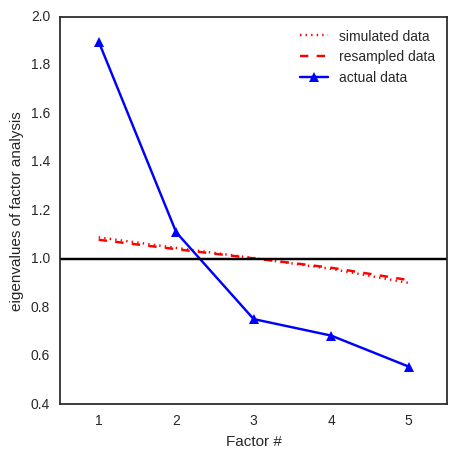

In [31]:
# PLOT RESULTS OF PARALLEL ANALYSIS FOR FACTORS
# -----------
f,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(pcValues.shape[0])+1,pcSim,'r:',label='simulated data');
ax.plot(np.arange(pcValues.shape[0])+1,pcSimR,'r--',label='resampled data');
ax.plot(np.arange(pcValues.shape[0])+1,pcValues,'b^-',label='actual data');
ax.axhline(y=1,linestyle='-',color='k')
plt.setp(ax,xlabel='Factor #',ylabel='eigenvalues of factor analysis',xlim=(0.5,pcValues.shape[0]+.5));
plt.legend()

# if exportFigs:
#     plt.savefig(op.join(outDir,"faParallel.svg"), format='svg')

[ 0.40337274  0.61912401  0.76414694  0.88785502  1.        ]
[ 0.40337274  0.21575127  0.14502293  0.12370808  0.11214498]


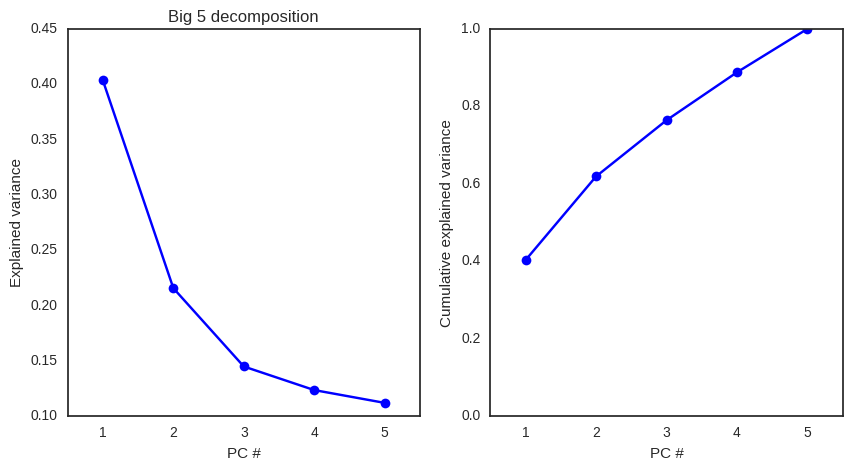

In [32]:
from sklearn.decomposition import PCA
nCompMax = 5;
# reduce dimensionality with PCA
pca = PCA()
pca.fit(NEOdf)
f,ax = plt.subplots(1,2,figsize=(10,5));
ax[0].plot(np.arange(nCompMax)+1,pca.explained_variance_ratio_[0:nCompMax],'bo-');
plt.setp(ax[0], title='Big 5 decomposition',xlim=(0.5,nCompMax+.5),xlabel='PC #', ylabel='Explained variance');
ax[1].plot(np.arange(nCompMax)+1,np.cumsum(pca.explained_variance_ratio_[0:nCompMax]),'bo-');
plt.setp(ax[1], xlim=(0.5,nCompMax+.5),xlabel='PC #', ylabel='Cumulative explained variance',ylim=(0,1));

print np.cumsum(pca.explained_variance_ratio_[0:nCompMax])
print (pca.explained_variance_ratio_[0:nCompMax])


In [33]:
tmp = pca.transform(NEOdf)
tmp.shape

(884, 5)

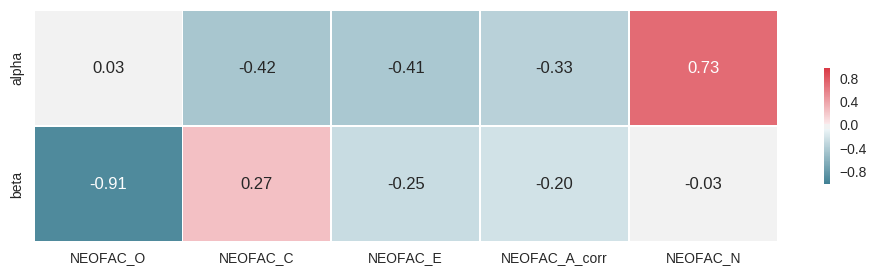

In [34]:
fig  = plt.figure(figsize=(12,3))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(pca.components_[0:2,:], annot=True, fmt=".2f", cmap=cmap, vmin=-1.,vmax=1.,
            square=False,linewidths=.5, cbar_kws={"shrink": .5},
            xticklabels=['NEOFAC_O','NEOFAC_C','NEOFAC_E','NEOFAC_A_corr','NEOFAC_N'],
            yticklabels=['alpha','beta'],
           )
if True:#exportFigs:
    plt.savefig(op.join(resultsDir,"pca2.svg"), format='svg')

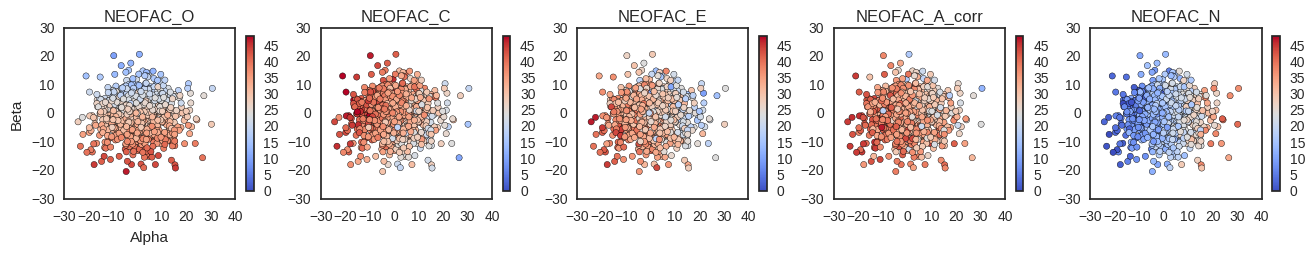

In [35]:
alpha = tmp[:,0]
beta  = tmp[:,1]
sizes = 20*np.ones(alpha.shape[0])
fig = plt.figure(figsize=(16,4));
reorder = np.argsort(sizes)
for iScore,score in enumerate(NEOitems):
    ax = fig.add_subplot(1,len(NEOitems),iScore+1)
    plt.scatter(alpha[reorder],beta[reorder],s=sizes[reorder],c=np.ravel(NEOdf[score][reorder]),cmap=plt.cm.coolwarm,vmin=0,vmax=48)
    ax.set_aspect(1./ax.get_data_ratio())
    plt.title(score)
    if iScore==0:
        plt.xlabel('Alpha')
        plt.ylabel('Beta')
    plt.colorbar(shrink=.5)

if True:#exportFigs:
    plt.savefig(op.join(resultsDir,"pca.svg"), format='svg')

In [36]:
df['alpha']  = alpha
df['beta']   = beta
df_ = df[['PMAT24_A_CR',
         'alpha', 'beta',
          'NEOFAC_O','NEOFAC_C','NEOFAC_E','NEOFAC_A_corr','NEOFAC_N',
         ]].copy()

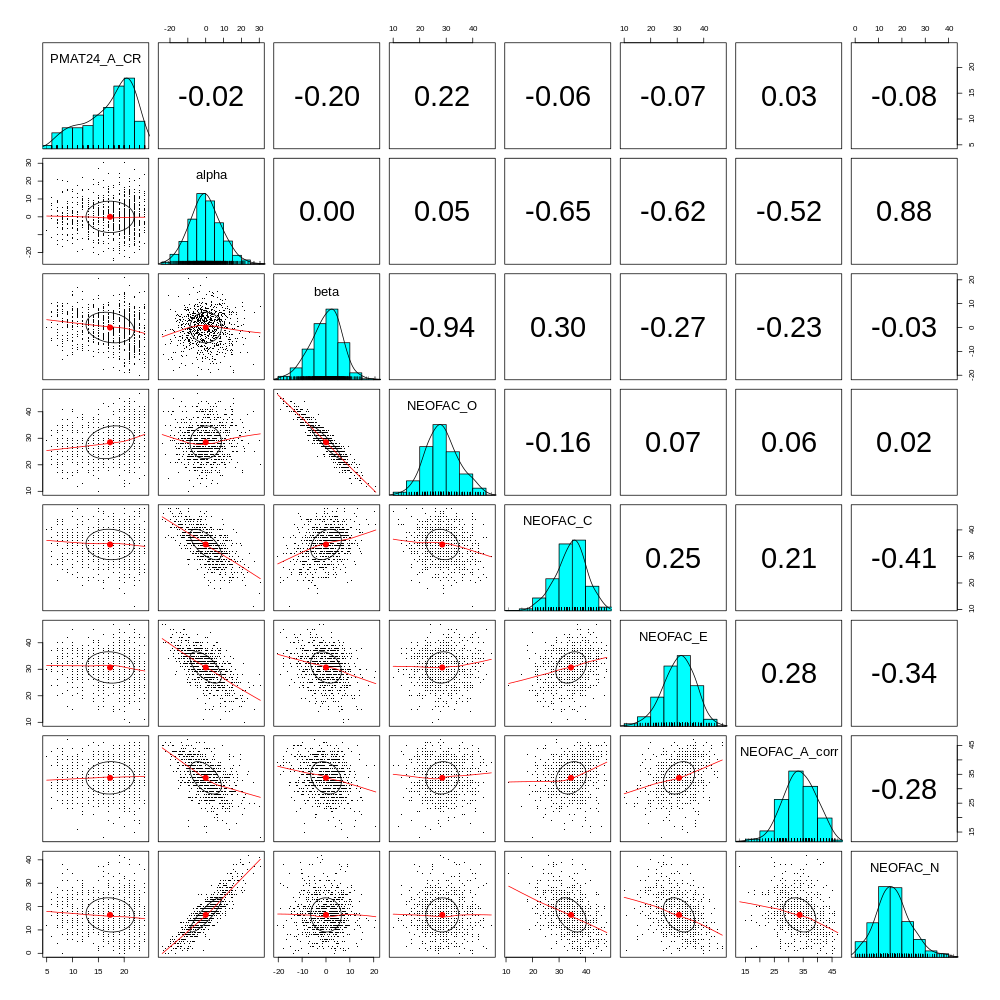

In [37]:
%%R -i df_ -w 1000 -h 1000
pairs.panels(df_,pch=".")

In [38]:
sScores = ['beta','alpha']

# re-save with alpha & beta
df.to_csv(dataFile, sep=',', encoding='utf-8')  

nPerm = 1000
#----------------------
# predict!
#----------------------
config.queue     = True
launchSubproc    = False
config.sgeopts   = '-l mem_free=2G' 
config.overwrite = False
filterThr = .01
decon     = 'deconH+IQ'
                            
for session in ['REST12']:#
    fcMatFile   =  op.join(outDir,'fcMats_'+session+'.mat')
    for fctype in ['Pearson']:#,'invPearson']:
        print ('{}, nsub{}, {}, {}, {}, {}'.format(
            config.release,df.shape[0],config.pipelineName,config.parcellationName,session,fctype))
        for model in ['elnet']:#'Finn'
            print '> {} thr{:.2f}'.format(model,filterThr)
            for score in sScores:
                print '--------> '+ score
                thisOutDir = op.join(outDir,'{}_{}_{}_{}_{}_{}_{}_{}_thr{:.2f}'.format(
                    score,config.pipelineName,config.parcellationName, session, decon, fctype, model, config.release,filterThr))
                if not op.isdir(thisOutDir):
                    mkdir(thisOutDir)
                # REAL & PERMUTED PREDICTIONS
                jPerm = list()
                print 'Checking existing results'
                printProgressBar(0, nPerm, prefix = 'Progress:', suffix = 'Complete', length = 50)
                for thisPerm in range(nPerm+1): 
                    thisOutDir_ = op.join(thisOutDir,'{0:04d}'.format(thisPerm))
                    if not op.isdir(thisOutDir_):
                        mkdir(thisOutDir_)
                    resFile    = op.join(thisOutDir_,'result.mat')
                    if (not op.isfile(resFile)) or config.overwrite:
                        jPerm.append(thisPerm)
                    printProgressBar(thisPerm, nPerm, prefix = 'Progress:', suffix = 'Complete', length = 50)
                    
                if len(jPerm)>0:
                    print 'Computing missing results'
                    # run this thrice, just in case some jobs fail -- it happens
                    for rep in range(3):
                        runPredictionParJD(fcMatFile,dataFile,SM=score,model=model,session=session,decon=decon,fctype=fctype,
                                           outDir=thisOutDir,confounds=confoundLists[decon],filterThr=filterThr,iPerm=jPerm)
                        checkProgress(pause=10,verbose=False)
                        sleep(10)
                        
                    # merge cross-validation folds, save results
                    print 'Merging CV folds for each permutation'
                    printProgressBar(0, nPerm, prefix = 'Progress:', suffix = 'Complete', length = 50)
                    for thisPerm in jPerm:
                        thisOutDir_ = op.join(thisOutDir,'{0:04d}'.format(thisPerm))
                        resFile     = op.join(thisOutDir_,'result.mat') 
                        if (not op.isfile(resFile)) or config.overwrite:
                            predictions_posneg = np.zeros([df.shape[0],1])
                            predictions_pos    = np.zeros([df.shape[0],1])
                            predictions_neg    = np.zeros([df.shape[0],1])
                            obs                = np.zeros([df.shape[0],1])
                            for el in np.unique(df['Family_ID']):
                                test_index    = list(df.ix[df['Family_ID']==el].index)
                                test_subjects = list(df.ix[df['Family_ID']==el]['Subject'])
                                cvResFile = op.join(thisOutDir_, '{}.mat'.format(
                                    '_'.join(['%s' % test_sub for test_sub in test_subjects])))
                                results = sio.loadmat(cvResFile) 
                                if model=='Finn':
                                    predictions_posneg[test_index] = results['pred_posneg'].T
                                    predictions_pos[test_index]    = results['pred_pos'].T
                                    predictions_neg[test_index]    = results['pred_neg'].T
                                else:
                                    predictions_pos[test_index]    = results['pred'].T
                                obs[test_index]                    = results['score'].T

                            if model=='Finn':
                                rho_posneg,p_posneg   = stats.pearsonr(np.ravel(predictions_posneg),np.ravel(obs))
                                rho_pos,p_pos         = stats.pearsonr(np.ravel(predictions_pos),np.ravel(obs))
                                rho_neg,p_neg         = stats.pearsonr(np.ravel(predictions_neg),np.ravel(obs))
                                results = {'obs':obs,
                                           'pred_posneg':predictions_posneg, 'rho_posneg':rho_posneg, 'p_posneg': p_posneg,
                                           'pred_pos':predictions_pos, 'rho_pos':rho_pos, 'p_pos': p_pos,
                                           'pred_neg':predictions_neg, 'rho_neg':rho_neg, 'p_neg': p_neg}
                            else:
                                rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.ravel(obs))
                                results = {'obs':obs,
                                           'pred':predictions_pos, 'rho':rho, 'p': p}
                            # save result
                            sio.savemat(resFile,results)
                        printProgressBar(thisPerm, nPerm, prefix = 'Progress:', suffix = 'Complete', length = 50)

all+MEG2, nsub884, A, Glasser, REST12, Pearson
> elnet thr0.01
--------> beta
Checking existing results
Progress: |##################################################| 100.0% Complete()
--------> alpha
Checking existing results
Progress: |##################################################| 100.0% Complete()


beta
Pearson r=0.272
R-squared=0.050
nRMSD    =0.975
alpha
Pearson r=0.075
R-squared=-0.096
nRMSD    =1.047


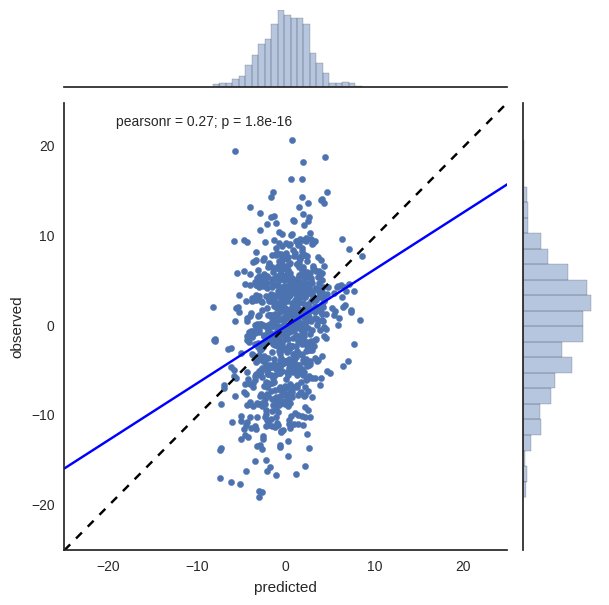

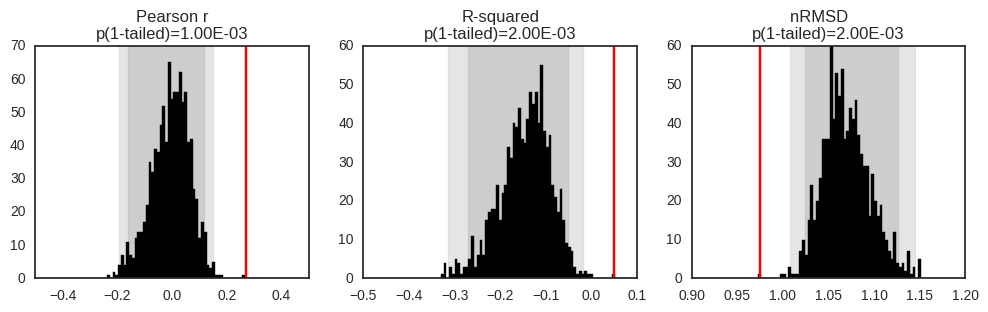

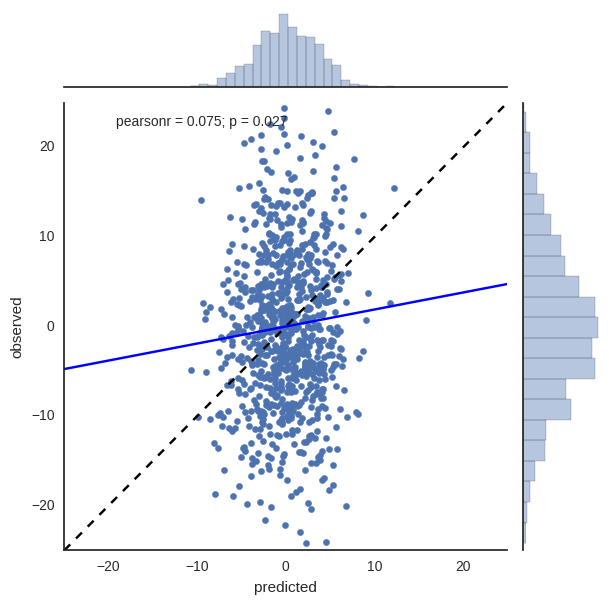

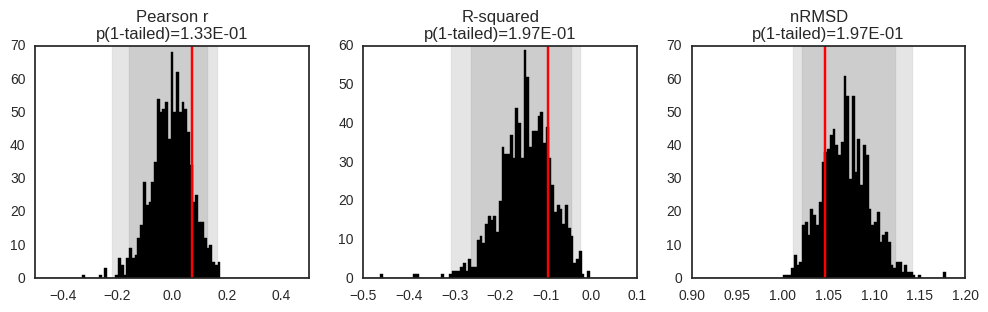

In [39]:
nPerm     = 1000
session   = 'REST12'
fctype    = 'Pearson'
model     = 'elnet'
filterThr = .01
decon     = 'deconH+IQ'

for iScore, score in enumerate(sScores):
    print score
    thisOutDir = op.join(outDir,'{}_{}_{}_{}_{}_{}_{}_{}_thr{:.2f}'.format(
                    score,config.pipelineName,config.parcellationName, session, decon, fctype, model, config.release,filterThr))

    outFileStats = op.join(thisOutDir,'fitStats.mat')

    if not op.isfile(outFileStats):
        fitMeas      = ['Pearson r','R-squared','nRMSD']
        fitPerm      = np.empty([nPerm+1,3])
        fitPerm[:]   = np.nan
        if nPerm>0:
            printProgressBar(0, nPerm, prefix = 'Progress:', suffix = 'Complete', length = 50)
        for thisPerm in range(nPerm+1):
            resDir    = op.join(thisOutDir,'{0:04d}'.format(thisPerm))
            ## MAKE SURE RESULTS.MAT EXISTS, AND HAS OBSERVED DATA SAVED
            resFile   = op.join(resDir,'result.mat')
            rePackage = False
            if (not op.isfile(resFile)) or config.overwrite:
                rePackage = True
            else:
                res       = sio.loadmat(resFile)
                if 'obs' not in res.keys():
                    rePackage = True
            if rePackage: 
                # merge cross-validation folds, save results
                obs              = np.zeros([df.shape[0],1])
                pred             = np.zeros([df.shape[0],1])
                for el in np.unique(df['Family_ID']):
                    test_index    = list(df.ix[df['Family_ID']==el].index)
                    test_subjects = list(df.ix[df['Family_ID']==el]['Subject'])
                    cvResFile = op.join(resDir,'{}.mat'.format(
                        '_'.join(['%s' % test_sub for test_sub in test_subjects])))
                    try:
                        results = sio.loadmat(cvResFile) 
                    except:
                        print 'Missing prediction!'+cvResFile

                    if model=='Finn':
                        pred_pos[test_index]    = results['pred_pos'].T
                        pred_neg[test_index]    = results['pred_neg'].T
                        pred_posneg[test_index] = results['pred_posneg'].T
                    else:
                        pred[test_index] = results['pred'].T
                    obs[test_index]      = results['score'].T

                if model=='Finn':
                    rho_posneg,p_posneg   = stats.pearsonr(np.ravel(pred_posneg),np.ravel(obs))
                    rho_pos,p_pos         = stats.pearsonr(np.ravel(pred_pos),np.ravel(obs))
                    rho_neg,p_neg         = stats.pearsonr(np.ravel(pred_neg),np.ravel(obs))
                    res = {'obs':obs,
                               'pred_posneg':pred_posneg, 'rho_posneg':rho_posneg, 'p_posneg': p_posneg,
                               'pred_pos':pred_pos, 'rho_pos':rho_pos, 'p_pos': p_pos,
                               'pred_neg':pred_neg, 'rho_neg':rho_neg, 'p_neg': p_neg}
                else:
                    rho,p   = stats.pearsonr(np.ravel(pred),np.ravel(obs))
                    res = {'obs':obs,
                               'pred':pred, 'rho':rho, 'p': p}
                # save result
                sio.savemat(resFile,res)
            else:
                res       = sio.loadmat(resFile)

            if model == 'Finn': 
                pred = res['pred_pos'].reshape(-1,)
                obs  = res['obs'].reshape(-1,)
            else:
                pred = res['pred'].reshape(-1,)
                obs  = res['obs'].reshape(-1,)

            fitPerm[thisPerm,0] = stats.pearsonr(obs,pred)[0]
            # compute R^2
            fitPerm[thisPerm,1] = 1 - np.sum(np.square(obs-pred)) / np.sum(np.square(obs-np.mean(obs)))
            # compute nRMSD = sqrt(1-R^2)
            fitPerm[thisPerm,2] = np.sqrt(1 - fitPerm[thisPerm,1])
            if nPerm>0:
                printProgressBar(thisPerm, nPerm, prefix = 'Progress:', suffix = 'Complete', length = 50)               
        #save fitPerm
        res = {'fitPerm':fitPerm,'fitMeas':fitMeas}
        # save result
        sio.savemat(outFileStats,res)
    else:
        res     = sio.loadmat(outFileStats)
        fitPerm = res['fitPerm']
        fitMeas = res['fitMeas']

    resFile   = op.join(thisOutDir,'0000','result.mat')
    res       = sio.loadmat(resFile)
    if model == 'Finn': 
        pred0 = res['pred_pos'].reshape(-1,)
        obs0  = res['obs'].reshape(-1,)
    else:
        pred0 = res['pred'].reshape(-1,)
        obs0  = res['obs'].reshape(-1,)

    # plot three fit measures and their null distributions
    nSub  = len(pred0)

    # PLOT OBSERVED vs. PREDICTED (cf. Pineiro et al, Ecological Modeling 2008)
    g  = sns.jointplot(pred0,obs0)
    # adjust the axes
    lims = [-25,25]
    g.ax_joint.set_xlim(lims)
    g.ax_joint.set_ylim(lims)
    g.ax_joint.set_xlabel('predicted')
    g.ax_joint.set_ylabel('observed')
    # PLOT THE 1:1 line
    line = plt.Line2D(lims,lims, c='k', linestyle='--')
    g.ax_joint.add_line(line)
    # FIT REGRESSION LINE
    regr = linear_model.LinearRegression()
    regr.fit(pred0.reshape(-1,1), obs0.reshape(-1,1))
    line = plt.Line2D(np.array(lims).reshape(-1,1),regr.predict(np.array(lims).reshape(-1,1)), c='b', linestyle='-')
    g.ax_joint.add_line(line)
    if True:#exportFigs:
        plt.savefig(op.join(resultsDir,"{}_{}_{}_obsVSpred.svg".format(score,model,decon)), format='svg')


    f, ax = plt.subplots(1, 3, sharey=False,figsize=(12,3))
    for i,meas in enumerate(fitMeas):
        if meas=='Pearson r':
            lims = [-.5,.5]
        elif meas=='R-squared':
            lims = [-.5,.1]
        elif meas[0:5]=='nRMSD':
            lims = [0.9,1.2]
        print '{}={:.3f}'.format(meas,fitPerm[0,i])
        if nPerm>0:
            xs       = np.linspace(lims[0],lims[1],100)
            empThr05 = [np.percentile(fitPerm[1:,i],[2.5, 97.5],interpolation='midpoint')]
            empThr01 = [np.percentile(fitPerm[1:,i],[.5, 99.5],interpolation='midpoint')]
            empThr   = np.vstack((empThr05, empThr01))
            Ns, bins = np.histogram(fitPerm[1:,i], xs)
            ax[i].hist(fitPerm[1:,i], bins,color='k')
            v        = ax[i].get_ylim()
            ax[i].fill(np.hstack([empThr[1,:], empThr[1,::-1]]),[v[0], v[0], v[1], v[1]],'k',alpha=0.1)
            ax[i].fill(np.hstack([empThr[0,:], empThr[0,::-1]]),[v[0], v[0], v[1], v[1]],'k',alpha=0.1)
            # true
            line = plt.Line2D([fitPerm[0,i],fitPerm[0,i]],[v[0],v[1]], c='r', linestyle='-')
            ax[i].add_line(line)
            ax[i].set_xlim(lims)
            if meas in ['Pearson r','R-squared']:
                p = ((nPerm-np.where(np.argsort(np.ravel(fitPerm[:,i]))==0)[0][0])+1)/np.float(nPerm)
            else:
                p = ((np.where(np.argsort(np.ravel(fitPerm[:,i]))==0)[0][0])+1)/np.float(nPerm)
            ax[i].set_title('{}\np(1-tailed)={:.2E}'.format(fitMeas[i],p))

    if True:#exportFigs:
        plt.savefig(op.join(resultsDir,"{}_{}_{}_predStats.svg".format(score,model,decon)), format='svg')